In [83]:
import datetime
from copy import copy
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
%matplotlib inline
import seaborn as sns
import ipywidgets
import pickle
import gc

from sklearn.model_selection import train_test_split, StratifiedKFold, cross_validate, GridSearchCV
from sklearn.metrics import accuracy_score, roc_auc_score

import xgboost
from xgboost import XGBClassifier
from lightgbm import LGBMClassifier
from catboost import CatBoostClassifier, cv, Pool
import optuna
from optuna.integration import lightgbm as lgb

In [56]:
train_df = pd.read_csv('dataset/train_16_0246.csv')
test_df = pd.read_csv('dataset/test_16_0246.csv')

In [57]:
ID = test_df['id']
x = train_df.drop(columns=['y', 'id'])
y = train_df['y']
test_df = test_df.drop(columns=['y', 'id'])

In [58]:
x_train, x_test, y_train, y_test = train_test_split(x, y,
                                                    test_size=0.2,
                                                    stratify=y,
                                                    shuffle=True,
                                                    random_state=18)

In [59]:
skf = StratifiedKFold(n_splits=5, shuffle=True, random_state=18)

# ＜XGBoost＞

In [6]:
def obj_xgb(trial):
    
    param_xgb = {
        'objective': 'binary:logistic',
        'booster': 'gbtree',
        'eval_metric': 'auc',
        'eta': trial.suggest_discrete_uniform('eta', 0.01, 0.03, 0.01),
        'n_estimators': 10000,
        'early_stopping_rounds': 100,
        'max_depth': trial.suggest_int('max_depth', 6, 10),
        'min_child_weight': trial.suggest_int('min_child_weight', 1, 5),
        'subsample': trial.suggest_discrete_uniform('subsample', 0.8, 1.0, 0.1),
        'colsample_bytree': trial.suggest_discrete_uniform('colsample_bytree', 0.80, 1.00, 0.05),
        'gamma': 0.0,
        'alpha': 0.0,
        'seed': 18
    }
    
    xgb = XGBClassifier(**param_xgb)
    xgb.fit(x_train, y_train, eval_set=[(x_train, y_train), (x_test, y_test)], verbose=False)
    predictions = xgb.predict_proba(x_test)[:,1]
    auc_score = roc_auc_score(y_test, predictions)
    
    return auc_score

In [7]:
%%time

study_xgb = optuna.create_study(direction='maximize')
study_xgb.optimize(obj_xgb, n_trials=300, n_jobs=-1)
print(study_xgb.best_params)
print(study_xgb.best_value)
xgb_best_params = study_xgb.best_params

[I 2020-08-17 02:14:53,571] Finished trial#0 resulted in value: 0.7946481910299664. Current best value is 0.7946481910299664 with parameters: {'eta': 0.02, 'max_depth': 6, 'min_child_weight': 4, 'subsample': 1.0, 'colsample_bytree': 0.8500000000000001}.
[I 2020-08-17 02:15:20,929] Finished trial#5 resulted in value: 0.7864861584444203. Current best value is 0.7946481910299664 with parameters: {'eta': 0.02, 'max_depth': 6, 'min_child_weight': 4, 'subsample': 1.0, 'colsample_bytree': 0.8500000000000001}.
[I 2020-08-17 02:16:05,837] Finished trial#3 resulted in value: 0.7967774787640174. Current best value is 0.7967774787640174 with parameters: {'eta': 0.02, 'max_depth': 6, 'min_child_weight': 1, 'subsample': 0.9, 'colsample_bytree': 0.9}.
[I 2020-08-17 02:17:32,972] Finished trial#2 resulted in value: 0.7885495430399648. Current best value is 0.7967774787640174 with parameters: {'eta': 0.02, 'max_depth': 6, 'min_child_weight': 1, 'subsample': 0.9, 'colsample_bytree': 0.9}.
[I 2020-08-17 

{'eta': 0.01, 'max_depth': 6, 'min_child_weight': 1, 'subsample': 0.9, 'colsample_bytree': 0.8500000000000001}
0.8083451390034686
CPU times: user 20h 14min 46s, sys: 1h 20s, total: 21h 15min 6s
Wall time: 3h 40min 18s


In [8]:
xgb_best_params

{'eta': 0.01,
 'max_depth': 6,
 'min_child_weight': 1,
 'subsample': 0.9,
 'colsample_bytree': 0.8500000000000001}

In [60]:
xgb_best_params = {
        'objective': 'binary:logistic',
        'booster': 'gbtree',
        'eval_metric': 'auc',
        'eta': 0.01,
        'n_estimators': 10000,
        'early_stopping_rounds': 100,
        'max_depth': 6,
        'min_child_weight': 1,
        'subsample': 0.9,
        'colsample_bytree': 0.85,
        'gamma': 0.0,
        'alpha': 0.0,
        'seed': 18
}

xgb_model = XGBClassifier(**xgb_best_params)
xgb_model.fit(x_train, y_train, eval_set=[(x_test, y_test)], verbose=False)

XGBClassifier(alpha=0.0, base_score=0.5, booster='gbtree', colsample_bylevel=1,
              colsample_bynode=1, colsample_bytree=0.85,
              early_stopping_rounds=100, eta=0.01, eval_metric='auc', gamma=0.0,
              gpu_id=-1, importance_type='gain', interaction_constraints=None,
              learning_rate=0.00999999978, max_delta_step=0, max_depth=6,
              min_child_weight=1, missing=nan, monotone_constraints=None,
              n_estimators=10000, n_jobs=0, num_parallel_tree=1,
              random_state=18, reg_alpha=0, reg_lambda=1, scale_pos_weight=1,
              seed=18, subsample=0.9, tree_method=None,
              validate_parameters=False, ...)

In [11]:
train_score_xgb = xgb_model.score(x_train, y_train)
test_score_xgb = xgb_model.score(x_test, y_test)

xgb_p = xgb_model.predict(x_test)

acc_xgb = accuracy_score(xgb_p, y_test)
auc_xgb = roc_auc_score(xgb_p, y_test)

print('train score:{}, test_score:{}'.format(train_score_xgb, test_score_xgb))
print('acc:{}, auc:{}'.format(acc_xgb, auc_xgb))

train score:0.9980166051660516, test_score:0.9273062730627306
acc:0.9273062730627306, auc:0.765620514292745


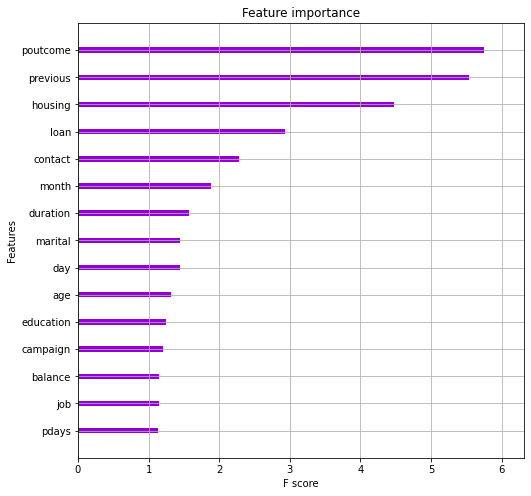

In [17]:
_, ax = plt.subplots(figsize=(8, 8))
xgboost.plot_importance(xgb_model,
                    ax=ax,
                    importance_type='gain',
                    color='darkviolet',
                    show_values=False)
plt.show()

In [18]:
pred_xgb = xgb_model.predict_proba(test_df)
xgb_p = pd.DataFrame(pred_xgb)
xgb_p.head()

,0,1
0,0.149779,0.850221
1,0.863433,0.136567
2,0.998994,0.001006
3,0.999946,0.000054
4,0.997146,0.002854


In [20]:
now = datetime.datetime.now()

xgb_name = 'models/XG_' + now.strftime('%d_%H%M') + '.pkl'
pickle.dump(xgb_model, open(xgb_name, 'wb'))

# ＜LightGBM＞

In [21]:
lgb_train = lgb.Dataset(x_train, y_train)
lgb_eval = lgb.Dataset(x_test, y_test, reference=lgb_train)

In [22]:
es = 1000

lgb_params = {
    'n_estimations': 10000,
    'learning_rate': 0.01,
    'max_depth': 7,
    'metric': 'auc',
    'rondom_state': 18
}

In [23]:
%%time

best_lgb = lgb.train(lgb_params,
                     lgb_train,
                     valid_sets=lgb_eval,
                     early_stopping_rounds=es,
                     verbosity=-1)

/home/awax2/miniconda3/envs/lab/lib/python3.7/site-packages/optuna/_experimental.py:87: ExperimentalWarning: train is experimental (supported from v0.18.0). The interface can change in the future.
  ExperimentalWarning
tune_feature_fraction, val_score: -inf:   0%|          | 0/7 [00:00<?, ?it/s]

[1]	valid_0's auc: 0.732187
Training until validation scores don't improve for 1000 rounds
[2]	valid_0's auc: 0.778119
[3]	valid_0's auc: 0.787321
[4]	valid_0's auc: 0.8078
[5]	valid_0's auc: 0.802806
[6]	valid_0's auc: 0.812091
[7]	valid_0's auc: 0.81416
[8]	valid_0's auc: 0.81794
[9]	valid_0's auc: 0.816723
[10]	valid_0's auc: 0.816889
[11]	valid_0's auc: 0.818442
[12]	valid_0's auc: 0.818436
[13]	valid_0's auc: 0.817801
[14]	valid_0's auc: 0.81817
[15]	valid_0's auc: 0.819476
[16]	valid_0's auc: 0.822971
[17]	valid_0's auc: 0.821322
[18]	valid_0's auc: 0.8215
[19]	valid_0's auc: 0.822542
[20]	valid_0's auc: 0.821786
[21]	valid_0's auc: 0.821687
[22]	valid_0's auc: 0.821633
[23]	valid_0's auc: 0.822791
[24]	valid_0's auc: 0.823271
[25]	valid_0's auc: 0.822479
[26]	valid_0's auc: 0.82225
[27]	valid_0's auc: 0.822338
[28]	valid_0's auc: 0.822544
[29]	valid_0's auc: 0.822027
[30]	valid_0's auc: 0.822122
[31]	valid_0's auc: 0.820801
[32]	valid_0's auc: 0.82071
[33]	valid_0's auc: 0.82035

tune_feature_fraction, val_score: 0.843643:  14%|#4        | 1/7 [00:09<00:57,  9.51s/it]

[1]	valid_0's auc: 0.740394
Training until validation scores don't improve for 1000 rounds
[2]	valid_0's auc: 0.786809
[3]	valid_0's auc: 0.796198
[4]	valid_0's auc: 0.803318
[5]	valid_0's auc: 0.806871
[6]	valid_0's auc: 0.807704
[7]	valid_0's auc: 0.80608
[8]	valid_0's auc: 0.811837
[9]	valid_0's auc: 0.813359
[10]	valid_0's auc: 0.812346
[11]	valid_0's auc: 0.813112
[12]	valid_0's auc: 0.815139
[13]	valid_0's auc: 0.814461
[14]	valid_0's auc: 0.814232
[15]	valid_0's auc: 0.814642
[16]	valid_0's auc: 0.817312
[17]	valid_0's auc: 0.818136
[18]	valid_0's auc: 0.819361
[19]	valid_0's auc: 0.823024
[20]	valid_0's auc: 0.822292
[21]	valid_0's auc: 0.822368
[22]	valid_0's auc: 0.822755
[23]	valid_0's auc: 0.823089
[24]	valid_0's auc: 0.823288
[25]	valid_0's auc: 0.823124
[26]	valid_0's auc: 0.823033
[27]	valid_0's auc: 0.822673
[28]	valid_0's auc: 0.822047
[29]	valid_0's auc: 0.821575
[30]	valid_0's auc: 0.821567
[31]	valid_0's auc: 0.82107
[32]	valid_0's auc: 0.821455
[33]	valid_0's auc: 

tune_feature_fraction, val_score: 0.843643:  29%|##8       | 2/7 [00:15<00:42,  8.50s/it]

[1]	valid_0's auc: 0.76002
Training until validation scores don't improve for 1000 rounds
[2]	valid_0's auc: 0.790397
[3]	valid_0's auc: 0.78774
[4]	valid_0's auc: 0.79733
[5]	valid_0's auc: 0.804202
[6]	valid_0's auc: 0.804168
[7]	valid_0's auc: 0.804778
[8]	valid_0's auc: 0.806039
[9]	valid_0's auc: 0.807083
[10]	valid_0's auc: 0.807006
[11]	valid_0's auc: 0.806725
[12]	valid_0's auc: 0.807624
[13]	valid_0's auc: 0.807613
[14]	valid_0's auc: 0.808739
[15]	valid_0's auc: 0.80829
[16]	valid_0's auc: 0.809244
[17]	valid_0's auc: 0.810732
[18]	valid_0's auc: 0.812407
[19]	valid_0's auc: 0.816179
[20]	valid_0's auc: 0.816125
[21]	valid_0's auc: 0.817034
[22]	valid_0's auc: 0.817731
[23]	valid_0's auc: 0.817565
[24]	valid_0's auc: 0.816961
[25]	valid_0's auc: 0.817203
[26]	valid_0's auc: 0.817171
[27]	valid_0's auc: 0.817026
[28]	valid_0's auc: 0.816831
[29]	valid_0's auc: 0.816853
[30]	valid_0's auc: 0.817106
[31]	valid_0's auc: 0.817164
[32]	valid_0's auc: 0.817775
[33]	valid_0's auc: 0.

tune_feature_fraction, val_score: 0.843643:  43%|####2     | 3/7 [00:21<00:30,  7.74s/it]

[1]	valid_0's auc: 0.781623
Training until validation scores don't improve for 1000 rounds
[2]	valid_0's auc: 0.786447
[3]	valid_0's auc: 0.786585
[4]	valid_0's auc: 0.7909
[5]	valid_0's auc: 0.791816
[6]	valid_0's auc: 0.792032
[7]	valid_0's auc: 0.7993
[8]	valid_0's auc: 0.802409
[9]	valid_0's auc: 0.802094
[10]	valid_0's auc: 0.800807
[11]	valid_0's auc: 0.803167
[12]	valid_0's auc: 0.803399
[13]	valid_0's auc: 0.80626
[14]	valid_0's auc: 0.807571
[15]	valid_0's auc: 0.806923
[16]	valid_0's auc: 0.80833
[17]	valid_0's auc: 0.808546
[18]	valid_0's auc: 0.808488
[19]	valid_0's auc: 0.809723
[20]	valid_0's auc: 0.809685
[21]	valid_0's auc: 0.809715
[22]	valid_0's auc: 0.810489
[23]	valid_0's auc: 0.809814
[24]	valid_0's auc: 0.810239
[25]	valid_0's auc: 0.810039
[26]	valid_0's auc: 0.810018
[27]	valid_0's auc: 0.809976
[28]	valid_0's auc: 0.809663
[29]	valid_0's auc: 0.809787
[30]	valid_0's auc: 0.809733
[31]	valid_0's auc: 0.810069
[32]	valid_0's auc: 0.810848
[33]	valid_0's auc: 0.81

tune_feature_fraction, val_score: 0.843643:  57%|#####7    | 4/7 [00:27<00:21,  7.16s/it]

[1]	valid_0's auc: 0.783478
Training until validation scores don't improve for 1000 rounds
[2]	valid_0's auc: 0.784127
[3]	valid_0's auc: 0.785038
[4]	valid_0's auc: 0.790758
[5]	valid_0's auc: 0.790028
[6]	valid_0's auc: 0.793992
[7]	valid_0's auc: 0.799343
[8]	valid_0's auc: 0.799539
[9]	valid_0's auc: 0.800317
[10]	valid_0's auc: 0.802179
[11]	valid_0's auc: 0.805227
[12]	valid_0's auc: 0.804653
[13]	valid_0's auc: 0.807125
[14]	valid_0's auc: 0.808413
[15]	valid_0's auc: 0.807556
[16]	valid_0's auc: 0.808
[17]	valid_0's auc: 0.807922
[18]	valid_0's auc: 0.808561
[19]	valid_0's auc: 0.808776
[20]	valid_0's auc: 0.809442
[21]	valid_0's auc: 0.809196
[22]	valid_0's auc: 0.808836
[23]	valid_0's auc: 0.808179
[24]	valid_0's auc: 0.808587
[25]	valid_0's auc: 0.80797
[26]	valid_0's auc: 0.808042
[27]	valid_0's auc: 0.807647
[28]	valid_0's auc: 0.807147
[29]	valid_0's auc: 0.807791
[30]	valid_0's auc: 0.80762
[31]	valid_0's auc: 0.80783
[32]	valid_0's auc: 0.807647
[33]	valid_0's auc: 0.80

tune_feature_fraction, val_score: 0.843643:  71%|#######1  | 5/7 [00:33<00:13,  6.78s/it]

[1]	valid_0's auc: 0.783076
Training until validation scores don't improve for 1000 rounds
[2]	valid_0's auc: 0.782987
[3]	valid_0's auc: 0.785027
[4]	valid_0's auc: 0.792693
[5]	valid_0's auc: 0.786954
[6]	valid_0's auc: 0.792233
[7]	valid_0's auc: 0.800757
[8]	valid_0's auc: 0.80053
[9]	valid_0's auc: 0.800872
[10]	valid_0's auc: 0.801328
[11]	valid_0's auc: 0.803059
[12]	valid_0's auc: 0.80142
[13]	valid_0's auc: 0.8036
[14]	valid_0's auc: 0.80478
[15]	valid_0's auc: 0.803366
[16]	valid_0's auc: 0.804853
[17]	valid_0's auc: 0.805639
[18]	valid_0's auc: 0.806182
[19]	valid_0's auc: 0.805881
[20]	valid_0's auc: 0.806059
[21]	valid_0's auc: 0.806342
[22]	valid_0's auc: 0.805108
[23]	valid_0's auc: 0.805262
[24]	valid_0's auc: 0.806336
[25]	valid_0's auc: 0.806153
[26]	valid_0's auc: 0.805644
[27]	valid_0's auc: 0.804734
[28]	valid_0's auc: 0.804263
[29]	valid_0's auc: 0.804494
[30]	valid_0's auc: 0.804235
[31]	valid_0's auc: 0.804325
[32]	valid_0's auc: 0.804229
[33]	valid_0's auc: 0.8

tune_feature_fraction, val_score: 0.843643:  86%|########5 | 6/7 [00:39<00:06,  6.45s/it]

[1]	valid_0's auc: 0.783076
Training until validation scores don't improve for 1000 rounds
[2]	valid_0's auc: 0.77666
[3]	valid_0's auc: 0.77658
[4]	valid_0's auc: 0.776786
[5]	valid_0's auc: 0.780172
[6]	valid_0's auc: 0.780404
[7]	valid_0's auc: 0.780382
[8]	valid_0's auc: 0.779664
[9]	valid_0's auc: 0.779736
[10]	valid_0's auc: 0.781095
[11]	valid_0's auc: 0.781262
[12]	valid_0's auc: 0.778336
[13]	valid_0's auc: 0.780808
[14]	valid_0's auc: 0.778888
[15]	valid_0's auc: 0.780497
[16]	valid_0's auc: 0.782366
[17]	valid_0's auc: 0.782254
[18]	valid_0's auc: 0.782516
[19]	valid_0's auc: 0.782767
[20]	valid_0's auc: 0.782518
[21]	valid_0's auc: 0.78259
[22]	valid_0's auc: 0.782495
[23]	valid_0's auc: 0.782485
[24]	valid_0's auc: 0.782524
[25]	valid_0's auc: 0.782982
[26]	valid_0's auc: 0.783595
[27]	valid_0's auc: 0.783608
[28]	valid_0's auc: 0.783227
[29]	valid_0's auc: 0.785057
[30]	valid_0's auc: 0.785025
[31]	valid_0's auc: 0.785094
[32]	valid_0's auc: 0.785249
[33]	valid_0's auc: 0

tune_num_leaves, val_score: 0.843643:   0%|          | 0/20 [00:00<?, ?it/s]

[1]	valid_0's auc: 0.712784
Training until validation scores don't improve for 1000 rounds
[2]	valid_0's auc: 0.77378
[3]	valid_0's auc: 0.77848
[4]	valid_0's auc: 0.801152
[5]	valid_0's auc: 0.797294
[6]	valid_0's auc: 0.80549
[7]	valid_0's auc: 0.806992
[8]	valid_0's auc: 0.811608
[9]	valid_0's auc: 0.81071
[10]	valid_0's auc: 0.812128
[11]	valid_0's auc: 0.814686
[12]	valid_0's auc: 0.814375
[13]	valid_0's auc: 0.81373
[14]	valid_0's auc: 0.814588
[15]	valid_0's auc: 0.816019
[16]	valid_0's auc: 0.820006
[17]	valid_0's auc: 0.818672
[18]	valid_0's auc: 0.819569
[19]	valid_0's auc: 0.8205
[20]	valid_0's auc: 0.820129
[21]	valid_0's auc: 0.819657
[22]	valid_0's auc: 0.819289
[23]	valid_0's auc: 0.820683
[24]	valid_0's auc: 0.821161
[25]	valid_0's auc: 0.820911
[26]	valid_0's auc: 0.82073
[27]	valid_0's auc: 0.820563
[28]	valid_0's auc: 0.820586
[29]	valid_0's auc: 0.819883
[30]	valid_0's auc: 0.82011
[31]	valid_0's auc: 0.81922
[32]	valid_0's auc: 0.819046
[33]	valid_0's auc: 0.818878

tune_num_leaves, val_score: 0.843643:   5%|5         | 1/20 [00:05<01:44,  5.48s/it]

[1]	valid_0's auc: 0.735063
Training until validation scores don't improve for 1000 rounds
[2]	valid_0's auc: 0.77255
[3]	valid_0's auc: 0.780197
[4]	valid_0's auc: 0.80685
[5]	valid_0's auc: 0.802267
[6]	valid_0's auc: 0.810589
[7]	valid_0's auc: 0.813387
[8]	valid_0's auc: 0.818421
[9]	valid_0's auc: 0.818233
[10]	valid_0's auc: 0.81872
[11]	valid_0's auc: 0.820374
[12]	valid_0's auc: 0.820704
[13]	valid_0's auc: 0.820594
[14]	valid_0's auc: 0.821642
[15]	valid_0's auc: 0.822946
[16]	valid_0's auc: 0.825703
[17]	valid_0's auc: 0.825114
[18]	valid_0's auc: 0.825758
[19]	valid_0's auc: 0.826778
[20]	valid_0's auc: 0.826341
[21]	valid_0's auc: 0.826228
[22]	valid_0's auc: 0.826241
[23]	valid_0's auc: 0.827135
[24]	valid_0's auc: 0.826827
[25]	valid_0's auc: 0.825997
[26]	valid_0's auc: 0.825821
[27]	valid_0's auc: 0.825743
[28]	valid_0's auc: 0.825831
[29]	valid_0's auc: 0.825347
[30]	valid_0's auc: 0.824828
[31]	valid_0's auc: 0.823368
[32]	valid_0's auc: 0.823391
[33]	valid_0's auc: 0

tune_num_leaves, val_score: 0.843950:  10%|#         | 2/20 [00:12<01:46,  5.89s/it]

[1]	valid_0's auc: 0.735063
Training until validation scores don't improve for 1000 rounds
[2]	valid_0's auc: 0.772995
[3]	valid_0's auc: 0.780627
[4]	valid_0's auc: 0.806944
[5]	valid_0's auc: 0.802569
[6]	valid_0's auc: 0.810929
[7]	valid_0's auc: 0.813595
[8]	valid_0's auc: 0.818857
[9]	valid_0's auc: 0.818939
[10]	valid_0's auc: 0.819369
[11]	valid_0's auc: 0.820959
[12]	valid_0's auc: 0.821247
[13]	valid_0's auc: 0.821095
[14]	valid_0's auc: 0.822108
[15]	valid_0's auc: 0.823367
[16]	valid_0's auc: 0.826111
[17]	valid_0's auc: 0.825556
[18]	valid_0's auc: 0.82621
[19]	valid_0's auc: 0.82721
[20]	valid_0's auc: 0.826752
[21]	valid_0's auc: 0.826687
[22]	valid_0's auc: 0.826585
[23]	valid_0's auc: 0.827418
[24]	valid_0's auc: 0.827164
[25]	valid_0's auc: 0.826314
[26]	valid_0's auc: 0.826088
[27]	valid_0's auc: 0.826001
[28]	valid_0's auc: 0.826075
[29]	valid_0's auc: 0.825568
[30]	valid_0's auc: 0.82502
[31]	valid_0's auc: 0.823555
[32]	valid_0's auc: 0.82356
[33]	valid_0's auc: 0.

tune_num_leaves, val_score: 0.844206:  15%|#5        | 3/20 [00:19<01:43,  6.10s/it]

[1]	valid_0's auc: 0.735063
Training until validation scores don't improve for 1000 rounds
[2]	valid_0's auc: 0.774357
[3]	valid_0's auc: 0.78192
[4]	valid_0's auc: 0.807781
[5]	valid_0's auc: 0.801928
[6]	valid_0's auc: 0.810679
[7]	valid_0's auc: 0.813035
[8]	valid_0's auc: 0.818543
[9]	valid_0's auc: 0.818665
[10]	valid_0's auc: 0.818964
[11]	valid_0's auc: 0.820476
[12]	valid_0's auc: 0.82083
[13]	valid_0's auc: 0.820609
[14]	valid_0's auc: 0.821762
[15]	valid_0's auc: 0.822995
[16]	valid_0's auc: 0.82581
[17]	valid_0's auc: 0.82491
[18]	valid_0's auc: 0.82561
[19]	valid_0's auc: 0.826694
[20]	valid_0's auc: 0.826022
[21]	valid_0's auc: 0.825912
[22]	valid_0's auc: 0.825985
[23]	valid_0's auc: 0.826872
[24]	valid_0's auc: 0.826656
[25]	valid_0's auc: 0.825827
[26]	valid_0's auc: 0.825481
[27]	valid_0's auc: 0.825464
[28]	valid_0's auc: 0.82554
[29]	valid_0's auc: 0.824994
[30]	valid_0's auc: 0.824551
[31]	valid_0's auc: 0.823139
[32]	valid_0's auc: 0.822947
[33]	valid_0's auc: 0.82

tune_num_leaves, val_score: 0.844206:  20%|##        | 4/20 [00:25<01:39,  6.23s/it]

[1]	valid_0's auc: 0.735063
Training until validation scores don't improve for 1000 rounds
[2]	valid_0's auc: 0.77255
[3]	valid_0's auc: 0.780197
[4]	valid_0's auc: 0.80685
[5]	valid_0's auc: 0.802267
[6]	valid_0's auc: 0.810589
[7]	valid_0's auc: 0.813387
[8]	valid_0's auc: 0.818421
[9]	valid_0's auc: 0.818233
[10]	valid_0's auc: 0.81872
[11]	valid_0's auc: 0.820374
[12]	valid_0's auc: 0.820704
[13]	valid_0's auc: 0.820594
[14]	valid_0's auc: 0.821642
[15]	valid_0's auc: 0.822946
[16]	valid_0's auc: 0.825703
[17]	valid_0's auc: 0.825114
[18]	valid_0's auc: 0.825758
[19]	valid_0's auc: 0.826778
[20]	valid_0's auc: 0.826341
[21]	valid_0's auc: 0.826228
[22]	valid_0's auc: 0.826241
[23]	valid_0's auc: 0.827135
[24]	valid_0's auc: 0.826827
[25]	valid_0's auc: 0.825997
[26]	valid_0's auc: 0.825821
[27]	valid_0's auc: 0.825743
[28]	valid_0's auc: 0.825831
[29]	valid_0's auc: 0.825347
[30]	valid_0's auc: 0.824828
[31]	valid_0's auc: 0.823368
[32]	valid_0's auc: 0.823391
[33]	valid_0's auc: 0

tune_num_leaves, val_score: 0.844206:  25%|##5       | 5/20 [00:32<01:37,  6.48s/it]

[1]	valid_0's auc: 0.734915
Training until validation scores don't improve for 1000 rounds
[2]	valid_0's auc: 0.776971
[3]	valid_0's auc: 0.784999
[4]	valid_0's auc: 0.806807
[5]	valid_0's auc: 0.801969
[6]	valid_0's auc: 0.811529
[7]	valid_0's auc: 0.813779
[8]	valid_0's auc: 0.817999
[9]	valid_0's auc: 0.817384
[10]	valid_0's auc: 0.817429
[11]	valid_0's auc: 0.819098
[12]	valid_0's auc: 0.819
[13]	valid_0's auc: 0.818324
[14]	valid_0's auc: 0.818813
[15]	valid_0's auc: 0.819961
[16]	valid_0's auc: 0.823442
[17]	valid_0's auc: 0.822019
[18]	valid_0's auc: 0.822054
[19]	valid_0's auc: 0.823098
[20]	valid_0's auc: 0.822449
[21]	valid_0's auc: 0.822297
[22]	valid_0's auc: 0.822545
[23]	valid_0's auc: 0.823688
[24]	valid_0's auc: 0.824158
[25]	valid_0's auc: 0.823309
[26]	valid_0's auc: 0.823035
[27]	valid_0's auc: 0.823052
[28]	valid_0's auc: 0.823283
[29]	valid_0's auc: 0.822645
[30]	valid_0's auc: 0.822772
[31]	valid_0's auc: 0.82137
[32]	valid_0's auc: 0.821217
[33]	valid_0's auc: 0.

tune_num_leaves, val_score: 0.844206:  30%|###       | 6/20 [00:38<01:27,  6.27s/it]

[1]	valid_0's auc: 0.705366
Training until validation scores don't improve for 1000 rounds
[2]	valid_0's auc: 0.770466
[3]	valid_0's auc: 0.773267
[4]	valid_0's auc: 0.791794
[5]	valid_0's auc: 0.78665
[6]	valid_0's auc: 0.794612
[7]	valid_0's auc: 0.797027
[8]	valid_0's auc: 0.801832
[9]	valid_0's auc: 0.800926
[10]	valid_0's auc: 0.802327
[11]	valid_0's auc: 0.804675
[12]	valid_0's auc: 0.802814
[13]	valid_0's auc: 0.801874
[14]	valid_0's auc: 0.804268
[15]	valid_0's auc: 0.806987
[16]	valid_0's auc: 0.811264
[17]	valid_0's auc: 0.810876
[18]	valid_0's auc: 0.811453
[19]	valid_0's auc: 0.81367
[20]	valid_0's auc: 0.81443
[21]	valid_0's auc: 0.815008
[22]	valid_0's auc: 0.814784
[23]	valid_0's auc: 0.815464
[24]	valid_0's auc: 0.815239
[25]	valid_0's auc: 0.815153
[26]	valid_0's auc: 0.814958
[27]	valid_0's auc: 0.814473
[28]	valid_0's auc: 0.81437
[29]	valid_0's auc: 0.813929
[30]	valid_0's auc: 0.81398
[31]	valid_0's auc: 0.813184
[32]	valid_0's auc: 0.813221
[33]	valid_0's auc: 0.8

tune_num_leaves, val_score: 0.844206:  35%|###5      | 7/20 [00:42<01:14,  5.75s/it]

[1]	valid_0's auc: 0.735063
Training until validation scores don't improve for 1000 rounds
[2]	valid_0's auc: 0.77255
[3]	valid_0's auc: 0.780197
[4]	valid_0's auc: 0.806847
[5]	valid_0's auc: 0.802267
[6]	valid_0's auc: 0.81059
[7]	valid_0's auc: 0.813388
[8]	valid_0's auc: 0.818424
[9]	valid_0's auc: 0.818281
[10]	valid_0's auc: 0.818752
[11]	valid_0's auc: 0.820415
[12]	valid_0's auc: 0.820741
[13]	valid_0's auc: 0.820621
[14]	valid_0's auc: 0.821665
[15]	valid_0's auc: 0.82297
[16]	valid_0's auc: 0.825702
[17]	valid_0's auc: 0.825061
[18]	valid_0's auc: 0.825735
[19]	valid_0's auc: 0.826749
[20]	valid_0's auc: 0.82633
[21]	valid_0's auc: 0.826198
[22]	valid_0's auc: 0.826215
[23]	valid_0's auc: 0.827104
[24]	valid_0's auc: 0.826797
[25]	valid_0's auc: 0.825989
[26]	valid_0's auc: 0.825799
[27]	valid_0's auc: 0.82572
[28]	valid_0's auc: 0.825733
[29]	valid_0's auc: 0.825254
[30]	valid_0's auc: 0.824745
[31]	valid_0's auc: 0.823295
[32]	valid_0's auc: 0.823298
[33]	valid_0's auc: 0.8

tune_num_leaves, val_score: 0.844376:  40%|####      | 8/20 [00:49<01:12,  6.05s/it]

[1]	valid_0's auc: 0.735063
Training until validation scores don't improve for 1000 rounds
[2]	valid_0's auc: 0.773776
[3]	valid_0's auc: 0.781009
[4]	valid_0's auc: 0.807003
[5]	valid_0's auc: 0.801665
[6]	valid_0's auc: 0.810262
[7]	valid_0's auc: 0.812861
[8]	valid_0's auc: 0.818303
[9]	valid_0's auc: 0.818262
[10]	valid_0's auc: 0.818783
[11]	valid_0's auc: 0.820403
[12]	valid_0's auc: 0.820704
[13]	valid_0's auc: 0.820582
[14]	valid_0's auc: 0.821696
[15]	valid_0's auc: 0.822892
[16]	valid_0's auc: 0.825643
[17]	valid_0's auc: 0.824937
[18]	valid_0's auc: 0.825653
[19]	valid_0's auc: 0.826739
[20]	valid_0's auc: 0.825989
[21]	valid_0's auc: 0.82591
[22]	valid_0's auc: 0.825965
[23]	valid_0's auc: 0.826892
[24]	valid_0's auc: 0.826624
[25]	valid_0's auc: 0.825772
[26]	valid_0's auc: 0.825575
[27]	valid_0's auc: 0.825421
[28]	valid_0's auc: 0.825566
[29]	valid_0's auc: 0.825088
[30]	valid_0's auc: 0.824491
[31]	valid_0's auc: 0.823122
[32]	valid_0's auc: 0.823111
[33]	valid_0's auc:

tune_num_leaves, val_score: 0.844376:  45%|####5     | 9/20 [00:56<01:07,  6.17s/it]

[1]	valid_0's auc: 0.735063
Training until validation scores don't improve for 1000 rounds
[2]	valid_0's auc: 0.772472
[3]	valid_0's auc: 0.78015
[4]	valid_0's auc: 0.806698
[5]	valid_0's auc: 0.802295
[6]	valid_0's auc: 0.810633
[7]	valid_0's auc: 0.813417
[8]	valid_0's auc: 0.818613
[9]	valid_0's auc: 0.818484
[10]	valid_0's auc: 0.818926
[11]	valid_0's auc: 0.820543
[12]	valid_0's auc: 0.820846
[13]	valid_0's auc: 0.820787
[14]	valid_0's auc: 0.821822
[15]	valid_0's auc: 0.823109
[16]	valid_0's auc: 0.825832
[17]	valid_0's auc: 0.825283
[18]	valid_0's auc: 0.825937
[19]	valid_0's auc: 0.82697
[20]	valid_0's auc: 0.826487
[21]	valid_0's auc: 0.826408
[22]	valid_0's auc: 0.826361
[23]	valid_0's auc: 0.827194
[24]	valid_0's auc: 0.826898
[25]	valid_0's auc: 0.826077
[26]	valid_0's auc: 0.825843
[27]	valid_0's auc: 0.825807
[28]	valid_0's auc: 0.825867
[29]	valid_0's auc: 0.825346
[30]	valid_0's auc: 0.824828
[31]	valid_0's auc: 0.823347
[32]	valid_0's auc: 0.823349
[33]	valid_0's auc: 

tune_num_leaves, val_score: 0.844376:  50%|#####     | 10/20 [01:02<01:02,  6.29s/it]

[1]	valid_0's auc: 0.735063
Training until validation scores don't improve for 1000 rounds
[2]	valid_0's auc: 0.77255
[3]	valid_0's auc: 0.780197
[4]	valid_0's auc: 0.80685
[5]	valid_0's auc: 0.802267
[6]	valid_0's auc: 0.810589
[7]	valid_0's auc: 0.813387
[8]	valid_0's auc: 0.818421
[9]	valid_0's auc: 0.818233
[10]	valid_0's auc: 0.81872
[11]	valid_0's auc: 0.820374
[12]	valid_0's auc: 0.820704
[13]	valid_0's auc: 0.820594
[14]	valid_0's auc: 0.821642
[15]	valid_0's auc: 0.822946
[16]	valid_0's auc: 0.825703
[17]	valid_0's auc: 0.825114
[18]	valid_0's auc: 0.825758
[19]	valid_0's auc: 0.826778
[20]	valid_0's auc: 0.826341
[21]	valid_0's auc: 0.826228
[22]	valid_0's auc: 0.826241
[23]	valid_0's auc: 0.827135
[24]	valid_0's auc: 0.826827
[25]	valid_0's auc: 0.825997
[26]	valid_0's auc: 0.825821
[27]	valid_0's auc: 0.825743
[28]	valid_0's auc: 0.825831
[29]	valid_0's auc: 0.825347
[30]	valid_0's auc: 0.824828
[31]	valid_0's auc: 0.823368
[32]	valid_0's auc: 0.823391
[33]	valid_0's auc: 0

tune_num_leaves, val_score: 0.844376:  55%|#####5    | 11/20 [01:09<00:58,  6.49s/it]

[1]	valid_0's auc: 0.735063
Training until validation scores don't improve for 1000 rounds
[2]	valid_0's auc: 0.77255
[3]	valid_0's auc: 0.780197
[4]	valid_0's auc: 0.80685
[5]	valid_0's auc: 0.802267
[6]	valid_0's auc: 0.810589
[7]	valid_0's auc: 0.813387
[8]	valid_0's auc: 0.818421
[9]	valid_0's auc: 0.818233
[10]	valid_0's auc: 0.81872
[11]	valid_0's auc: 0.820374
[12]	valid_0's auc: 0.820704
[13]	valid_0's auc: 0.820594
[14]	valid_0's auc: 0.821642
[15]	valid_0's auc: 0.822946
[16]	valid_0's auc: 0.825703
[17]	valid_0's auc: 0.825118
[18]	valid_0's auc: 0.825762
[19]	valid_0's auc: 0.82678
[20]	valid_0's auc: 0.826341
[21]	valid_0's auc: 0.82623
[22]	valid_0's auc: 0.826244
[23]	valid_0's auc: 0.827135
[24]	valid_0's auc: 0.826826
[25]	valid_0's auc: 0.825999
[26]	valid_0's auc: 0.825824
[27]	valid_0's auc: 0.825746
[28]	valid_0's auc: 0.825834
[29]	valid_0's auc: 0.825349
[30]	valid_0's auc: 0.82483
[31]	valid_0's auc: 0.82337
[32]	valid_0's auc: 0.823393
[33]	valid_0's auc: 0.823

tune_num_leaves, val_score: 0.844376:  60%|######    | 12/20 [01:16<00:52,  6.53s/it]

[1]	valid_0's auc: 0.735063
Training until validation scores don't improve for 1000 rounds
[2]	valid_0's auc: 0.77255
[3]	valid_0's auc: 0.780197
[4]	valid_0's auc: 0.80685
[5]	valid_0's auc: 0.802267
[6]	valid_0's auc: 0.810589
[7]	valid_0's auc: 0.813387
[8]	valid_0's auc: 0.818421
[9]	valid_0's auc: 0.818244
[10]	valid_0's auc: 0.818723
[11]	valid_0's auc: 0.820378
[12]	valid_0's auc: 0.820707
[13]	valid_0's auc: 0.820594
[14]	valid_0's auc: 0.82164
[15]	valid_0's auc: 0.822945
[16]	valid_0's auc: 0.825701
[17]	valid_0's auc: 0.825119
[18]	valid_0's auc: 0.825767
[19]	valid_0's auc: 0.826779
[20]	valid_0's auc: 0.826344
[21]	valid_0's auc: 0.826228
[22]	valid_0's auc: 0.826247
[23]	valid_0's auc: 0.827135
[24]	valid_0's auc: 0.826824
[25]	valid_0's auc: 0.826001
[26]	valid_0's auc: 0.825828
[27]	valid_0's auc: 0.825745
[28]	valid_0's auc: 0.825835
[29]	valid_0's auc: 0.825355
[30]	valid_0's auc: 0.824839
[31]	valid_0's auc: 0.823378
[32]	valid_0's auc: 0.823392
[33]	valid_0's auc: 0

tune_num_leaves, val_score: 0.844376:  65%|######5   | 13/20 [01:23<00:46,  6.62s/it]

[1]	valid_0's auc: 0.733257
Training until validation scores don't improve for 1000 rounds
[2]	valid_0's auc: 0.773989
[3]	valid_0's auc: 0.783035
[4]	valid_0's auc: 0.805708
[5]	valid_0's auc: 0.802191
[6]	valid_0's auc: 0.812435
[7]	valid_0's auc: 0.814387
[8]	valid_0's auc: 0.819487
[9]	valid_0's auc: 0.818731
[10]	valid_0's auc: 0.818623
[11]	valid_0's auc: 0.820148
[12]	valid_0's auc: 0.820184
[13]	valid_0's auc: 0.819988
[14]	valid_0's auc: 0.820633
[15]	valid_0's auc: 0.821587
[16]	valid_0's auc: 0.824706
[17]	valid_0's auc: 0.823206
[18]	valid_0's auc: 0.823913
[19]	valid_0's auc: 0.824924
[20]	valid_0's auc: 0.824688
[21]	valid_0's auc: 0.824706
[22]	valid_0's auc: 0.824865
[23]	valid_0's auc: 0.82567
[24]	valid_0's auc: 0.825896
[25]	valid_0's auc: 0.824929
[26]	valid_0's auc: 0.824681
[27]	valid_0's auc: 0.824644
[28]	valid_0's auc: 0.824834
[29]	valid_0's auc: 0.824305
[30]	valid_0's auc: 0.824223
[31]	valid_0's auc: 0.82279
[32]	valid_0's auc: 0.822532
[33]	valid_0's auc: 

tune_num_leaves, val_score: 0.844376:  70%|#######   | 14/20 [01:29<00:38,  6.42s/it]

[1]	valid_0's auc: 0.735063
Training until validation scores don't improve for 1000 rounds
[2]	valid_0's auc: 0.77255
[3]	valid_0's auc: 0.780197
[4]	valid_0's auc: 0.806846
[5]	valid_0's auc: 0.802267
[6]	valid_0's auc: 0.810587
[7]	valid_0's auc: 0.813388
[8]	valid_0's auc: 0.81843
[9]	valid_0's auc: 0.818349
[10]	valid_0's auc: 0.818813
[11]	valid_0's auc: 0.820478
[12]	valid_0's auc: 0.820792
[13]	valid_0's auc: 0.820707
[14]	valid_0's auc: 0.821743
[15]	valid_0's auc: 0.823026
[16]	valid_0's auc: 0.825749
[17]	valid_0's auc: 0.825177
[18]	valid_0's auc: 0.825876
[19]	valid_0's auc: 0.82689
[20]	valid_0's auc: 0.826475
[21]	valid_0's auc: 0.826364
[22]	valid_0's auc: 0.826351
[23]	valid_0's auc: 0.827237
[24]	valid_0's auc: 0.826932
[25]	valid_0's auc: 0.826112
[26]	valid_0's auc: 0.825916
[27]	valid_0's auc: 0.825829
[28]	valid_0's auc: 0.825856
[29]	valid_0's auc: 0.825372
[30]	valid_0's auc: 0.824908
[31]	valid_0's auc: 0.82344
[32]	valid_0's auc: 0.823452
[33]	valid_0's auc: 0.

tune_num_leaves, val_score: 0.844376:  75%|#######5  | 15/20 [01:35<00:32,  6.53s/it]

[1]	valid_0's auc: 0.735063
Training until validation scores don't improve for 1000 rounds
[2]	valid_0's auc: 0.77255
[3]	valid_0's auc: 0.780197
[4]	valid_0's auc: 0.80685
[5]	valid_0's auc: 0.802267
[6]	valid_0's auc: 0.810589
[7]	valid_0's auc: 0.813387
[8]	valid_0's auc: 0.818421
[9]	valid_0's auc: 0.818233
[10]	valid_0's auc: 0.81872
[11]	valid_0's auc: 0.820374
[12]	valid_0's auc: 0.820704
[13]	valid_0's auc: 0.820594
[14]	valid_0's auc: 0.821642
[15]	valid_0's auc: 0.822946
[16]	valid_0's auc: 0.825703
[17]	valid_0's auc: 0.825114
[18]	valid_0's auc: 0.825758
[19]	valid_0's auc: 0.826778
[20]	valid_0's auc: 0.826341
[21]	valid_0's auc: 0.826228
[22]	valid_0's auc: 0.826241
[23]	valid_0's auc: 0.827135
[24]	valid_0's auc: 0.826827
[25]	valid_0's auc: 0.825997
[26]	valid_0's auc: 0.825821
[27]	valid_0's auc: 0.825743
[28]	valid_0's auc: 0.825831
[29]	valid_0's auc: 0.825347
[30]	valid_0's auc: 0.824828
[31]	valid_0's auc: 0.823368
[32]	valid_0's auc: 0.823391
[33]	valid_0's auc: 0

tune_num_leaves, val_score: 0.844376:  80%|########  | 16/20 [01:42<00:26,  6.58s/it]

[1]	valid_0's auc: 0.736372
Training until validation scores don't improve for 1000 rounds
[2]	valid_0's auc: 0.773943
[3]	valid_0's auc: 0.782068
[4]	valid_0's auc: 0.807972
[5]	valid_0's auc: 0.803375
[6]	valid_0's auc: 0.812339
[7]	valid_0's auc: 0.815266
[8]	valid_0's auc: 0.820379
[9]	valid_0's auc: 0.819449
[10]	valid_0's auc: 0.819435
[11]	valid_0's auc: 0.820711
[12]	valid_0's auc: 0.820878
[13]	valid_0's auc: 0.820982
[14]	valid_0's auc: 0.821842
[15]	valid_0's auc: 0.822998
[16]	valid_0's auc: 0.825845
[17]	valid_0's auc: 0.824739
[18]	valid_0's auc: 0.825508
[19]	valid_0's auc: 0.826561
[20]	valid_0's auc: 0.826278
[21]	valid_0's auc: 0.826352
[22]	valid_0's auc: 0.826405
[23]	valid_0's auc: 0.827142
[24]	valid_0's auc: 0.827212
[25]	valid_0's auc: 0.82643
[26]	valid_0's auc: 0.826136
[27]	valid_0's auc: 0.826027
[28]	valid_0's auc: 0.826152
[29]	valid_0's auc: 0.825641
[30]	valid_0's auc: 0.825466
[31]	valid_0's auc: 0.824047
[32]	valid_0's auc: 0.823737
[33]	valid_0's auc:

tune_num_leaves, val_score: 0.844376:  85%|########5 | 17/20 [01:48<00:19,  6.46s/it]

[1]	valid_0's auc: 0.735493
Training until validation scores don't improve for 1000 rounds
[2]	valid_0's auc: 0.772486
[3]	valid_0's auc: 0.780794
[4]	valid_0's auc: 0.807084
[5]	valid_0's auc: 0.802168
[6]	valid_0's auc: 0.811637
[7]	valid_0's auc: 0.814705
[8]	valid_0's auc: 0.819728
[9]	valid_0's auc: 0.819053
[10]	valid_0's auc: 0.819222
[11]	valid_0's auc: 0.820493
[12]	valid_0's auc: 0.820726
[13]	valid_0's auc: 0.820726
[14]	valid_0's auc: 0.821813
[15]	valid_0's auc: 0.822964
[16]	valid_0's auc: 0.82581
[17]	valid_0's auc: 0.824651
[18]	valid_0's auc: 0.825363
[19]	valid_0's auc: 0.826532
[20]	valid_0's auc: 0.825951
[21]	valid_0's auc: 0.82602
[22]	valid_0's auc: 0.82618
[23]	valid_0's auc: 0.826956
[24]	valid_0's auc: 0.826966
[25]	valid_0's auc: 0.826164
[26]	valid_0's auc: 0.825902
[27]	valid_0's auc: 0.825773
[28]	valid_0's auc: 0.825819
[29]	valid_0's auc: 0.825314
[30]	valid_0's auc: 0.825116
[31]	valid_0's auc: 0.823756
[32]	valid_0's auc: 0.823464
[33]	valid_0's auc: 0

tune_num_leaves, val_score: 0.844376:  90%|######### | 18/20 [01:54<00:12,  6.37s/it]

[1]	valid_0's auc: 0.736413
Training until validation scores don't improve for 1000 rounds
[2]	valid_0's auc: 0.773575
[3]	valid_0's auc: 0.782733
[4]	valid_0's auc: 0.808149
[5]	valid_0's auc: 0.80278
[6]	valid_0's auc: 0.812438
[7]	valid_0's auc: 0.815032
[8]	valid_0's auc: 0.819607
[9]	valid_0's auc: 0.818718
[10]	valid_0's auc: 0.818677
[11]	valid_0's auc: 0.819827
[12]	valid_0's auc: 0.820049
[13]	valid_0's auc: 0.820225
[14]	valid_0's auc: 0.821219
[15]	valid_0's auc: 0.822166
[16]	valid_0's auc: 0.825271
[17]	valid_0's auc: 0.82364
[18]	valid_0's auc: 0.824361
[19]	valid_0's auc: 0.825354
[20]	valid_0's auc: 0.824915
[21]	valid_0's auc: 0.825186
[22]	valid_0's auc: 0.825322
[23]	valid_0's auc: 0.826116
[24]	valid_0's auc: 0.826292
[25]	valid_0's auc: 0.825455
[26]	valid_0's auc: 0.825204
[27]	valid_0's auc: 0.825111
[28]	valid_0's auc: 0.825147
[29]	valid_0's auc: 0.82458
[30]	valid_0's auc: 0.824539
[31]	valid_0's auc: 0.82311
[32]	valid_0's auc: 0.822873
[33]	valid_0's auc: 0.

tune_num_leaves, val_score: 0.844376:  95%|#########5| 19/20 [02:00<00:06,  6.25s/it]

[1]	valid_0's auc: 0.58114
Training until validation scores don't improve for 1000 rounds
[2]	valid_0's auc: 0.716618
[3]	valid_0's auc: 0.728474
[4]	valid_0's auc: 0.733358
[5]	valid_0's auc: 0.74498
[6]	valid_0's auc: 0.754494
[7]	valid_0's auc: 0.755571
[8]	valid_0's auc: 0.750847
[9]	valid_0's auc: 0.751657
[10]	valid_0's auc: 0.762568
[11]	valid_0's auc: 0.764718
[12]	valid_0's auc: 0.76365
[13]	valid_0's auc: 0.763271
[14]	valid_0's auc: 0.765099
[15]	valid_0's auc: 0.765684
[16]	valid_0's auc: 0.766202
[17]	valid_0's auc: 0.770068
[18]	valid_0's auc: 0.769926
[19]	valid_0's auc: 0.769897
[20]	valid_0's auc: 0.770379
[21]	valid_0's auc: 0.7688
[22]	valid_0's auc: 0.768368
[23]	valid_0's auc: 0.768941
[24]	valid_0's auc: 0.768593
[25]	valid_0's auc: 0.767646
[26]	valid_0's auc: 0.767649
[27]	valid_0's auc: 0.764314
[28]	valid_0's auc: 0.768715
[29]	valid_0's auc: 0.768858
[30]	valid_0's auc: 0.76539
[31]	valid_0's auc: 0.768782
[32]	valid_0's auc: 0.769146
[33]	valid_0's auc: 0.76

tune_num_leaves, val_score: 0.844376: 100%|##########| 20/20 [02:03<00:00,  6.19s/it]
tune_bagging_fraction_and_bagging_freq, val_score: 0.844376:   0%|          | 0/10 [00:00<?, ?it/s]

[1]	valid_0's auc: 0.713892
Training until validation scores don't improve for 1000 rounds
[2]	valid_0's auc: 0.764995
[3]	valid_0's auc: 0.777596
[4]	valid_0's auc: 0.802222
[5]	valid_0's auc: 0.795998
[6]	valid_0's auc: 0.810318
[7]	valid_0's auc: 0.810709
[8]	valid_0's auc: 0.816421
[9]	valid_0's auc: 0.816237
[10]	valid_0's auc: 0.816022
[11]	valid_0's auc: 0.819578
[12]	valid_0's auc: 0.818613
[13]	valid_0's auc: 0.81807
[14]	valid_0's auc: 0.818726
[15]	valid_0's auc: 0.82028
[16]	valid_0's auc: 0.822713
[17]	valid_0's auc: 0.824027
[18]	valid_0's auc: 0.824672
[19]	valid_0's auc: 0.826118
[20]	valid_0's auc: 0.825883
[21]	valid_0's auc: 0.825849
[22]	valid_0's auc: 0.826835
[23]	valid_0's auc: 0.828343
[24]	valid_0's auc: 0.828373
[25]	valid_0's auc: 0.8285
[26]	valid_0's auc: 0.828703
[27]	valid_0's auc: 0.828177
[28]	valid_0's auc: 0.827817
[29]	valid_0's auc: 0.8275
[30]	valid_0's auc: 0.827611
[31]	valid_0's auc: 0.826674
[32]	valid_0's auc: 0.827092
[33]	valid_0's auc: 0.82

tune_bagging_fraction_and_bagging_freq, val_score: 0.844376:  10%|#         | 1/10 [00:07<01:03,  7.09s/it][I 2020-08-17 11:48:17,445] Finished trial#0 resulted in value: 0.8436896085448398. Current best value is 0.8436896085448398 with parameters: {'bagging_fraction': 0.7888947616360291, 'bagging_freq': 7}.
tune_bagging_fraction_and_bagging_freq, val_score: 0.844376:  10%|#         | 1/10 [00:07<01:03,  7.09s/it]

[1]	valid_0's auc: 0.747963
Training until validation scores don't improve for 1000 rounds
[2]	valid_0's auc: 0.785419
[3]	valid_0's auc: 0.78744
[4]	valid_0's auc: 0.809341
[5]	valid_0's auc: 0.806776
[6]	valid_0's auc: 0.819221
[7]	valid_0's auc: 0.818723
[8]	valid_0's auc: 0.820634
[9]	valid_0's auc: 0.81798
[10]	valid_0's auc: 0.817125
[11]	valid_0's auc: 0.820789
[12]	valid_0's auc: 0.820912
[13]	valid_0's auc: 0.819491
[14]	valid_0's auc: 0.81999
[15]	valid_0's auc: 0.821595
[16]	valid_0's auc: 0.823247
[17]	valid_0's auc: 0.823585
[18]	valid_0's auc: 0.824472
[19]	valid_0's auc: 0.825831
[20]	valid_0's auc: 0.825855
[21]	valid_0's auc: 0.825819
[22]	valid_0's auc: 0.826317
[23]	valid_0's auc: 0.827091
[24]	valid_0's auc: 0.827199
[25]	valid_0's auc: 0.825921
[26]	valid_0's auc: 0.826032
[27]	valid_0's auc: 0.825751
[28]	valid_0's auc: 0.825519
[29]	valid_0's auc: 0.825452
[30]	valid_0's auc: 0.825909
[31]	valid_0's auc: 0.824834
[32]	valid_0's auc: 0.824969
[33]	valid_0's auc: 0

tune_bagging_fraction_and_bagging_freq, val_score: 0.845784:  20%|##        | 2/10 [00:13<00:56,  7.01s/it][I 2020-08-17 11:48:24,263] Finished trial#1 resulted in value: 0.8457838111547936. Current best value is 0.8457838111547936 with parameters: {'bagging_fraction': 0.6347029685728939, 'bagging_freq': 1}.
tune_bagging_fraction_and_bagging_freq, val_score: 0.845784:  20%|##        | 2/10 [00:13<00:56,  7.01s/it]

[1]	valid_0's auc: 0.714175
Training until validation scores don't improve for 1000 rounds
[2]	valid_0's auc: 0.768692
[3]	valid_0's auc: 0.778649
[4]	valid_0's auc: 0.803012
[5]	valid_0's auc: 0.798775
[6]	valid_0's auc: 0.810836
[7]	valid_0's auc: 0.814504
[8]	valid_0's auc: 0.818464
[9]	valid_0's auc: 0.818384
[10]	valid_0's auc: 0.818633
[11]	valid_0's auc: 0.821603
[12]	valid_0's auc: 0.821342
[13]	valid_0's auc: 0.820556
[14]	valid_0's auc: 0.821253
[15]	valid_0's auc: 0.82302
[16]	valid_0's auc: 0.825133
[17]	valid_0's auc: 0.825235
[18]	valid_0's auc: 0.826272
[19]	valid_0's auc: 0.827383
[20]	valid_0's auc: 0.82696
[21]	valid_0's auc: 0.826916
[22]	valid_0's auc: 0.827219
[23]	valid_0's auc: 0.828723
[24]	valid_0's auc: 0.828976
[25]	valid_0's auc: 0.828932
[26]	valid_0's auc: 0.829019
[27]	valid_0's auc: 0.829823
[28]	valid_0's auc: 0.829999
[29]	valid_0's auc: 0.830114
[30]	valid_0's auc: 0.829939
[31]	valid_0's auc: 0.8285
[32]	valid_0's auc: 0.828589
[33]	valid_0's auc: 0.

tune_bagging_fraction_and_bagging_freq, val_score: 0.845784:  30%|###       | 3/10 [00:20<00:48,  6.90s/it][I 2020-08-17 11:48:30,909] Finished trial#2 resulted in value: 0.8446293209226818. Current best value is 0.8457838111547936 with parameters: {'bagging_fraction': 0.6347029685728939, 'bagging_freq': 1}.
tune_bagging_fraction_and_bagging_freq, val_score: 0.845784:  30%|###       | 3/10 [00:20<00:48,  6.90s/it]

[1]	valid_0's auc: 0.730607
Training until validation scores don't improve for 1000 rounds
[2]	valid_0's auc: 0.779243
[3]	valid_0's auc: 0.788974
[4]	valid_0's auc: 0.809112
[5]	valid_0's auc: 0.810839
[6]	valid_0's auc: 0.818127
[7]	valid_0's auc: 0.817438
[8]	valid_0's auc: 0.819272
[9]	valid_0's auc: 0.818814
[10]	valid_0's auc: 0.819165
[11]	valid_0's auc: 0.823734
[12]	valid_0's auc: 0.823545
[13]	valid_0's auc: 0.82377
[14]	valid_0's auc: 0.824118
[15]	valid_0's auc: 0.825245
[16]	valid_0's auc: 0.828329
[17]	valid_0's auc: 0.827481
[18]	valid_0's auc: 0.827956
[19]	valid_0's auc: 0.829472
[20]	valid_0's auc: 0.829698
[21]	valid_0's auc: 0.830652
[22]	valid_0's auc: 0.831058
[23]	valid_0's auc: 0.831509
[24]	valid_0's auc: 0.831997
[25]	valid_0's auc: 0.831677
[26]	valid_0's auc: 0.83125
[27]	valid_0's auc: 0.830487
[28]	valid_0's auc: 0.830431
[29]	valid_0's auc: 0.830046
[30]	valid_0's auc: 0.830713
[31]	valid_0's auc: 0.829331
[32]	valid_0's auc: 0.829679
[33]	valid_0's auc: 

tune_bagging_fraction_and_bagging_freq, val_score: 0.845784:  40%|####      | 4/10 [00:27<00:41,  6.85s/it][I 2020-08-17 11:48:37,654] Finished trial#3 resulted in value: 0.845202061867401. Current best value is 0.8457838111547936 with parameters: {'bagging_fraction': 0.6347029685728939, 'bagging_freq': 1}.
tune_bagging_fraction_and_bagging_freq, val_score: 0.845784:  40%|####      | 4/10 [00:27<00:41,  6.85s/it]

[1]	valid_0's auc: 0.750325
Training until validation scores don't improve for 1000 rounds
[2]	valid_0's auc: 0.780314
[3]	valid_0's auc: 0.789221
[4]	valid_0's auc: 0.809708
[5]	valid_0's auc: 0.805294
[6]	valid_0's auc: 0.815556
[7]	valid_0's auc: 0.816653
[8]	valid_0's auc: 0.81993
[9]	valid_0's auc: 0.818686
[10]	valid_0's auc: 0.818468
[11]	valid_0's auc: 0.821911
[12]	valid_0's auc: 0.821946
[13]	valid_0's auc: 0.821578
[14]	valid_0's auc: 0.823275
[15]	valid_0's auc: 0.824588
[16]	valid_0's auc: 0.826925
[17]	valid_0's auc: 0.82687
[18]	valid_0's auc: 0.82783
[19]	valid_0's auc: 0.82868
[20]	valid_0's auc: 0.828361
[21]	valid_0's auc: 0.828278
[22]	valid_0's auc: 0.827927
[23]	valid_0's auc: 0.8293
[24]	valid_0's auc: 0.82963
[25]	valid_0's auc: 0.829683
[26]	valid_0's auc: 0.829446
[27]	valid_0's auc: 0.830171
[28]	valid_0's auc: 0.830641
[29]	valid_0's auc: 0.831201
[30]	valid_0's auc: 0.830913
[31]	valid_0's auc: 0.829545
[32]	valid_0's auc: 0.829614
[33]	valid_0's auc: 0.829

tune_bagging_fraction_and_bagging_freq, val_score: 0.845784:  50%|#####     | 5/10 [00:34<00:34,  6.97s/it][I 2020-08-17 11:48:44,890] Finished trial#4 resulted in value: 0.8446568200740011. Current best value is 0.8457838111547936 with parameters: {'bagging_fraction': 0.6347029685728939, 'bagging_freq': 1}.
tune_bagging_fraction_and_bagging_freq, val_score: 0.845784:  50%|#####     | 5/10 [00:34<00:34,  6.97s/it]

[1]	valid_0's auc: 0.728536
Training until validation scores don't improve for 1000 rounds
[2]	valid_0's auc: 0.770559
[3]	valid_0's auc: 0.777944
[4]	valid_0's auc: 0.803063
[5]	valid_0's auc: 0.798734
[6]	valid_0's auc: 0.808446
[7]	valid_0's auc: 0.811498
[8]	valid_0's auc: 0.816655
[9]	valid_0's auc: 0.81614
[10]	valid_0's auc: 0.817226
[11]	valid_0's auc: 0.819795
[12]	valid_0's auc: 0.820257
[13]	valid_0's auc: 0.819592
[14]	valid_0's auc: 0.820069
[15]	valid_0's auc: 0.821286
[16]	valid_0's auc: 0.824068
[17]	valid_0's auc: 0.82551
[18]	valid_0's auc: 0.825986
[19]	valid_0's auc: 0.827042
[20]	valid_0's auc: 0.826895
[21]	valid_0's auc: 0.826353
[22]	valid_0's auc: 0.826491
[23]	valid_0's auc: 0.827199
[24]	valid_0's auc: 0.827223
[25]	valid_0's auc: 0.826365
[26]	valid_0's auc: 0.826247
[27]	valid_0's auc: 0.826152
[28]	valid_0's auc: 0.826085
[29]	valid_0's auc: 0.825462
[30]	valid_0's auc: 0.825264
[31]	valid_0's auc: 0.823823
[32]	valid_0's auc: 0.823946
[33]	valid_0's auc: 

tune_bagging_fraction_and_bagging_freq, val_score: 0.845784:  60%|######    | 6/10 [00:41<00:27,  6.94s/it][I 2020-08-17 11:48:51,751] Finished trial#5 resulted in value: 0.8440717519235182. Current best value is 0.8457838111547936 with parameters: {'bagging_fraction': 0.6347029685728939, 'bagging_freq': 1}.
tune_bagging_fraction_and_bagging_freq, val_score: 0.845784:  60%|######    | 6/10 [00:41<00:27,  6.94s/it]

[1]	valid_0's auc: 0.703325
Training until validation scores don't improve for 1000 rounds
[2]	valid_0's auc: 0.760101
[3]	valid_0's auc: 0.769529
[4]	valid_0's auc: 0.795838
[5]	valid_0's auc: 0.794048
[6]	valid_0's auc: 0.809284
[7]	valid_0's auc: 0.809896
[8]	valid_0's auc: 0.81613
[9]	valid_0's auc: 0.816754
[10]	valid_0's auc: 0.817084
[11]	valid_0's auc: 0.819329
[12]	valid_0's auc: 0.81838
[13]	valid_0's auc: 0.81849
[14]	valid_0's auc: 0.81837
[15]	valid_0's auc: 0.82004
[16]	valid_0's auc: 0.822398
[17]	valid_0's auc: 0.824251
[18]	valid_0's auc: 0.825033
[19]	valid_0's auc: 0.826324
[20]	valid_0's auc: 0.825974
[21]	valid_0's auc: 0.825433
[22]	valid_0's auc: 0.826077
[23]	valid_0's auc: 0.827838
[24]	valid_0's auc: 0.828511
[25]	valid_0's auc: 0.828166
[26]	valid_0's auc: 0.828033
[27]	valid_0's auc: 0.827756
[28]	valid_0's auc: 0.82755
[29]	valid_0's auc: 0.827156
[30]	valid_0's auc: 0.827261
[31]	valid_0's auc: 0.826504
[32]	valid_0's auc: 0.826944
[33]	valid_0's auc: 0.82

tune_bagging_fraction_and_bagging_freq, val_score: 0.845784:  70%|#######   | 7/10 [00:48<00:20,  6.87s/it][I 2020-08-17 11:48:58,479] Finished trial#6 resulted in value: 0.8445387633726477. Current best value is 0.8457838111547936 with parameters: {'bagging_fraction': 0.6347029685728939, 'bagging_freq': 1}.
tune_bagging_fraction_and_bagging_freq, val_score: 0.845784:  70%|#######   | 7/10 [00:48<00:20,  6.87s/it]

[1]	valid_0's auc: 0.736565
Training until validation scores don't improve for 1000 rounds
[2]	valid_0's auc: 0.777467
[3]	valid_0's auc: 0.783903
[4]	valid_0's auc: 0.80589
[5]	valid_0's auc: 0.802859
[6]	valid_0's auc: 0.813849
[7]	valid_0's auc: 0.812878
[8]	valid_0's auc: 0.817684
[9]	valid_0's auc: 0.815113
[10]	valid_0's auc: 0.816376
[11]	valid_0's auc: 0.820736
[12]	valid_0's auc: 0.820888
[13]	valid_0's auc: 0.819682
[14]	valid_0's auc: 0.819594
[15]	valid_0's auc: 0.820937
[16]	valid_0's auc: 0.823762
[17]	valid_0's auc: 0.822936
[18]	valid_0's auc: 0.82387
[19]	valid_0's auc: 0.824324
[20]	valid_0's auc: 0.824425
[21]	valid_0's auc: 0.825176
[22]	valid_0's auc: 0.825725
[23]	valid_0's auc: 0.82708
[24]	valid_0's auc: 0.827394
[25]	valid_0's auc: 0.827007
[26]	valid_0's auc: 0.826837
[27]	valid_0's auc: 0.827805
[28]	valid_0's auc: 0.827279
[29]	valid_0's auc: 0.827602
[30]	valid_0's auc: 0.827709
[31]	valid_0's auc: 0.827066
[32]	valid_0's auc: 0.827446
[33]	valid_0's auc: 0

tune_bagging_fraction_and_bagging_freq, val_score: 0.845925:  80%|########  | 8/10 [00:54<00:13,  6.81s/it][I 2020-08-17 11:49:05,128] Finished trial#7 resulted in value: 0.845925099897779. Current best value is 0.845925099897779 with parameters: {'bagging_fraction': 0.4976941177049812, 'bagging_freq': 5}.
tune_bagging_fraction_and_bagging_freq, val_score: 0.845925:  80%|########  | 8/10 [00:54<00:13,  6.81s/it]

[1]	valid_0's auc: 0.733204
Training until validation scores don't improve for 1000 rounds
[2]	valid_0's auc: 0.777055
[3]	valid_0's auc: 0.784196
[4]	valid_0's auc: 0.805375
[5]	valid_0's auc: 0.802969
[6]	valid_0's auc: 0.811497
[7]	valid_0's auc: 0.812275
[8]	valid_0's auc: 0.818038
[9]	valid_0's auc: 0.816938
[10]	valid_0's auc: 0.817032
[11]	valid_0's auc: 0.820257
[12]	valid_0's auc: 0.821308
[13]	valid_0's auc: 0.821271
[14]	valid_0's auc: 0.822406
[15]	valid_0's auc: 0.82313
[16]	valid_0's auc: 0.826267
[17]	valid_0's auc: 0.825284
[18]	valid_0's auc: 0.825846
[19]	valid_0's auc: 0.826974
[20]	valid_0's auc: 0.826255
[21]	valid_0's auc: 0.826339
[22]	valid_0's auc: 0.827182
[23]	valid_0's auc: 0.828557
[24]	valid_0's auc: 0.828736
[25]	valid_0's auc: 0.827576
[26]	valid_0's auc: 0.827177
[27]	valid_0's auc: 0.826959
[28]	valid_0's auc: 0.826789
[29]	valid_0's auc: 0.826698
[30]	valid_0's auc: 0.827237
[31]	valid_0's auc: 0.827258
[32]	valid_0's auc: 0.827846
[33]	valid_0's auc:

tune_bagging_fraction_and_bagging_freq, val_score: 0.845925:  90%|######### | 9/10 [01:01<00:06,  6.87s/it][I 2020-08-17 11:49:12,158] Finished trial#8 resulted in value: 0.843763097656124. Current best value is 0.845925099897779 with parameters: {'bagging_fraction': 0.4976941177049812, 'bagging_freq': 5}.
tune_bagging_fraction_and_bagging_freq, val_score: 0.845925:  90%|######### | 9/10 [01:01<00:06,  6.87s/it]

[1]	valid_0's auc: 0.721443
Training until validation scores don't improve for 1000 rounds
[2]	valid_0's auc: 0.767681
[3]	valid_0's auc: 0.779501
[4]	valid_0's auc: 0.802809
[5]	valid_0's auc: 0.798105
[6]	valid_0's auc: 0.808443
[7]	valid_0's auc: 0.811227
[8]	valid_0's auc: 0.816097
[9]	valid_0's auc: 0.813409
[10]	valid_0's auc: 0.814166
[11]	valid_0's auc: 0.816594
[12]	valid_0's auc: 0.816903
[13]	valid_0's auc: 0.817703
[14]	valid_0's auc: 0.818709
[15]	valid_0's auc: 0.819708
[16]	valid_0's auc: 0.822634
[17]	valid_0's auc: 0.823061
[18]	valid_0's auc: 0.823566
[19]	valid_0's auc: 0.824457
[20]	valid_0's auc: 0.824451
[21]	valid_0's auc: 0.823906
[22]	valid_0's auc: 0.823996
[23]	valid_0's auc: 0.824976
[24]	valid_0's auc: 0.824685
[25]	valid_0's auc: 0.824446
[26]	valid_0's auc: 0.824051
[27]	valid_0's auc: 0.825136
[28]	valid_0's auc: 0.825354
[29]	valid_0's auc: 0.825806
[30]	valid_0's auc: 0.825711
[31]	valid_0's auc: 0.824415
[32]	valid_0's auc: 0.824011
[33]	valid_0's auc

tune_bagging_fraction_and_bagging_freq, val_score: 0.845925: 100%|##########| 10/10 [01:09<00:00,  6.97s/it][I 2020-08-17 11:49:19,363] Finished trial#9 resulted in value: 0.8443088135728225. Current best value is 0.845925099897779 with parameters: {'bagging_fraction': 0.4976941177049812, 'bagging_freq': 5}.
tune_bagging_fraction_and_bagging_freq, val_score: 0.845925: 100%|##########| 10/10 [01:09<00:00,  6.91s/it]
tune_feature_fraction, val_score: 0.845925:   0%|          | 0/3 [00:00<?, ?it/s]

[1]	valid_0's auc: 0.736565
Training until validation scores don't improve for 1000 rounds
[2]	valid_0's auc: 0.777467
[3]	valid_0's auc: 0.783903
[4]	valid_0's auc: 0.80589
[5]	valid_0's auc: 0.802859
[6]	valid_0's auc: 0.813849
[7]	valid_0's auc: 0.812878
[8]	valid_0's auc: 0.817684
[9]	valid_0's auc: 0.815113
[10]	valid_0's auc: 0.816376
[11]	valid_0's auc: 0.820736
[12]	valid_0's auc: 0.820888
[13]	valid_0's auc: 0.819682
[14]	valid_0's auc: 0.819594
[15]	valid_0's auc: 0.820937
[16]	valid_0's auc: 0.823762
[17]	valid_0's auc: 0.822936
[18]	valid_0's auc: 0.82387
[19]	valid_0's auc: 0.824324
[20]	valid_0's auc: 0.824425
[21]	valid_0's auc: 0.825176
[22]	valid_0's auc: 0.825725
[23]	valid_0's auc: 0.82708
[24]	valid_0's auc: 0.827394
[25]	valid_0's auc: 0.827007
[26]	valid_0's auc: 0.826837
[27]	valid_0's auc: 0.827805
[28]	valid_0's auc: 0.827279
[29]	valid_0's auc: 0.827602
[30]	valid_0's auc: 0.827709
[31]	valid_0's auc: 0.827066
[32]	valid_0's auc: 0.827446
[33]	valid_0's auc: 0

tune_feature_fraction, val_score: 0.845925:  33%|###3      | 1/3 [00:06<00:13,  6.61s/it]

[1]	valid_0's auc: 0.739936
Training until validation scores don't improve for 1000 rounds
[2]	valid_0's auc: 0.772961
[3]	valid_0's auc: 0.771942
[4]	valid_0's auc: 0.798599
[5]	valid_0's auc: 0.799746
[6]	valid_0's auc: 0.81141
[7]	valid_0's auc: 0.80934
[8]	valid_0's auc: 0.813237
[9]	valid_0's auc: 0.81304
[10]	valid_0's auc: 0.813951
[11]	valid_0's auc: 0.815268
[12]	valid_0's auc: 0.816161
[13]	valid_0's auc: 0.817735
[14]	valid_0's auc: 0.819304
[15]	valid_0's auc: 0.820822
[16]	valid_0's auc: 0.823444
[17]	valid_0's auc: 0.822694
[18]	valid_0's auc: 0.824921
[19]	valid_0's auc: 0.825233
[20]	valid_0's auc: 0.824352
[21]	valid_0's auc: 0.824829
[22]	valid_0's auc: 0.826397
[23]	valid_0's auc: 0.826628
[24]	valid_0's auc: 0.826672
[25]	valid_0's auc: 0.826847
[26]	valid_0's auc: 0.826422
[27]	valid_0's auc: 0.826019
[28]	valid_0's auc: 0.826109
[29]	valid_0's auc: 0.82539
[30]	valid_0's auc: 0.825415
[31]	valid_0's auc: 0.824507
[32]	valid_0's auc: 0.825004
[33]	valid_0's auc: 0.

tune_feature_fraction, val_score: 0.845925:  67%|######6   | 2/3 [00:13<00:06,  6.70s/it]

[1]	valid_0's auc: 0.739936
Training until validation scores don't improve for 1000 rounds
[2]	valid_0's auc: 0.772961
[3]	valid_0's auc: 0.771942
[4]	valid_0's auc: 0.798599
[5]	valid_0's auc: 0.799746
[6]	valid_0's auc: 0.81141
[7]	valid_0's auc: 0.80934
[8]	valid_0's auc: 0.813237
[9]	valid_0's auc: 0.81304
[10]	valid_0's auc: 0.813951
[11]	valid_0's auc: 0.815268
[12]	valid_0's auc: 0.816161
[13]	valid_0's auc: 0.817735
[14]	valid_0's auc: 0.819304
[15]	valid_0's auc: 0.820822
[16]	valid_0's auc: 0.823444
[17]	valid_0's auc: 0.822694
[18]	valid_0's auc: 0.824921
[19]	valid_0's auc: 0.825233
[20]	valid_0's auc: 0.824352
[21]	valid_0's auc: 0.824829
[22]	valid_0's auc: 0.826397
[23]	valid_0's auc: 0.826628
[24]	valid_0's auc: 0.826672
[25]	valid_0's auc: 0.826847
[26]	valid_0's auc: 0.826422
[27]	valid_0's auc: 0.826019
[28]	valid_0's auc: 0.826109
[29]	valid_0's auc: 0.82539
[30]	valid_0's auc: 0.825415
[31]	valid_0's auc: 0.824507
[32]	valid_0's auc: 0.825004
[33]	valid_0's auc: 0.

tune_feature_fraction, val_score: 0.845925: 100%|##########| 3/3 [00:20<00:00,  6.83s/it]
tune_lambda_l1_and_lambda_l2, val_score: 0.845925:   0%|          | 0/20 [00:00<?, ?it/s]

[1]	valid_0's auc: 0.738012
Training until validation scores don't improve for 1000 rounds
[2]	valid_0's auc: 0.77747
[3]	valid_0's auc: 0.784085
[4]	valid_0's auc: 0.806484
[5]	valid_0's auc: 0.803612
[6]	valid_0's auc: 0.814576
[7]	valid_0's auc: 0.813591
[8]	valid_0's auc: 0.818193
[9]	valid_0's auc: 0.815619
[10]	valid_0's auc: 0.816623
[11]	valid_0's auc: 0.820791
[12]	valid_0's auc: 0.820402
[13]	valid_0's auc: 0.819293
[14]	valid_0's auc: 0.819456
[15]	valid_0's auc: 0.820559
[16]	valid_0's auc: 0.823541
[17]	valid_0's auc: 0.822732
[18]	valid_0's auc: 0.823685
[19]	valid_0's auc: 0.824278
[20]	valid_0's auc: 0.824342
[21]	valid_0's auc: 0.825038
[22]	valid_0's auc: 0.825402
[23]	valid_0's auc: 0.826867
[24]	valid_0's auc: 0.827299
[25]	valid_0's auc: 0.827126
[26]	valid_0's auc: 0.826849
[27]	valid_0's auc: 0.827801
[28]	valid_0's auc: 0.827354
[29]	valid_0's auc: 0.827699
[30]	valid_0's auc: 0.827823
[31]	valid_0's auc: 0.827137
[32]	valid_0's auc: 0.827524
[33]	valid_0's auc:

tune_lambda_l1_and_lambda_l2, val_score: 0.845935:   5%|5         | 1/20 [00:06<02:09,  6.81s/it][I 2020-08-17 11:49:46,744] Finished trial#0 resulted in value: 0.8459350564870498. Current best value is 0.8459350564870498 with parameters: {'lambda_l1': 1.6319093568772325e-06, 'lambda_l2': 1.206555668246716}.
tune_lambda_l1_and_lambda_l2, val_score: 0.845935:   5%|5         | 1/20 [00:06<02:09,  6.81s/it]

[1]	valid_0's auc: 0.737956
Training until validation scores don't improve for 1000 rounds
[2]	valid_0's auc: 0.777744
[3]	valid_0's auc: 0.784218
[4]	valid_0's auc: 0.806451
[5]	valid_0's auc: 0.803349
[6]	valid_0's auc: 0.814175
[7]	valid_0's auc: 0.81323
[8]	valid_0's auc: 0.818015
[9]	valid_0's auc: 0.815287
[10]	valid_0's auc: 0.816529
[11]	valid_0's auc: 0.820743
[12]	valid_0's auc: 0.820372
[13]	valid_0's auc: 0.819394
[14]	valid_0's auc: 0.819478
[15]	valid_0's auc: 0.820647
[16]	valid_0's auc: 0.823628
[17]	valid_0's auc: 0.823071
[18]	valid_0's auc: 0.82396
[19]	valid_0's auc: 0.824412
[20]	valid_0's auc: 0.824482
[21]	valid_0's auc: 0.825405
[22]	valid_0's auc: 0.825769
[23]	valid_0's auc: 0.827303
[24]	valid_0's auc: 0.827659
[25]	valid_0's auc: 0.827334
[26]	valid_0's auc: 0.827055
[27]	valid_0's auc: 0.828064
[28]	valid_0's auc: 0.827545
[29]	valid_0's auc: 0.82793
[30]	valid_0's auc: 0.827973
[31]	valid_0's auc: 0.827441
[32]	valid_0's auc: 0.827752
[33]	valid_0's auc: 0

tune_lambda_l1_and_lambda_l2, val_score: 0.846459:  10%|#         | 2/20 [00:13<02:02,  6.80s/it][I 2020-08-17 11:49:53,516] Finished trial#1 resulted in value: 0.8464594368553109. Current best value is 0.8464594368553109 with parameters: {'lambda_l1': 0.07143297109476643, 'lambda_l2': 3.1601540331174966e-08}.
tune_lambda_l1_and_lambda_l2, val_score: 0.846459:  10%|#         | 2/20 [00:13<02:02,  6.80s/it]

[1]	valid_0's auc: 0.738927
Training until validation scores don't improve for 1000 rounds
[2]	valid_0's auc: 0.778301
[3]	valid_0's auc: 0.785014
[4]	valid_0's auc: 0.804829
[5]	valid_0's auc: 0.800988
[6]	valid_0's auc: 0.811955
[7]	valid_0's auc: 0.812071
[8]	valid_0's auc: 0.816009
[9]	valid_0's auc: 0.813487
[10]	valid_0's auc: 0.813859
[11]	valid_0's auc: 0.817583
[12]	valid_0's auc: 0.817295
[13]	valid_0's auc: 0.816821
[14]	valid_0's auc: 0.817249
[15]	valid_0's auc: 0.817876
[16]	valid_0's auc: 0.821196
[17]	valid_0's auc: 0.821336
[18]	valid_0's auc: 0.822719
[19]	valid_0's auc: 0.823639
[20]	valid_0's auc: 0.823721
[21]	valid_0's auc: 0.824716
[22]	valid_0's auc: 0.825068
[23]	valid_0's auc: 0.826438
[24]	valid_0's auc: 0.826793
[25]	valid_0's auc: 0.826533
[26]	valid_0's auc: 0.826333
[27]	valid_0's auc: 0.827206
[28]	valid_0's auc: 0.826993
[29]	valid_0's auc: 0.827251
[30]	valid_0's auc: 0.827401
[31]	valid_0's auc: 0.826843
[32]	valid_0's auc: 0.827165
[33]	valid_0's auc

tune_lambda_l1_and_lambda_l2, val_score: 0.846459:  15%|#5        | 3/20 [00:20<01:58,  6.94s/it][I 2020-08-17 11:50:00,802] Finished trial#2 resulted in value: 0.8454694674078163. Current best value is 0.8464594368553109 with parameters: {'lambda_l1': 0.07143297109476643, 'lambda_l2': 3.1601540331174966e-08}.
tune_lambda_l1_and_lambda_l2, val_score: 0.846459:  15%|#5        | 3/20 [00:20<01:58,  6.94s/it]

[1]	valid_0's auc: 0.744889
Training until validation scores don't improve for 1000 rounds
[2]	valid_0's auc: 0.779019
[3]	valid_0's auc: 0.787848
[4]	valid_0's auc: 0.809406
[5]	valid_0's auc: 0.80529
[6]	valid_0's auc: 0.81554
[7]	valid_0's auc: 0.81531
[8]	valid_0's auc: 0.819202
[9]	valid_0's auc: 0.816263
[10]	valid_0's auc: 0.81699
[11]	valid_0's auc: 0.820701
[12]	valid_0's auc: 0.819952
[13]	valid_0's auc: 0.819815
[14]	valid_0's auc: 0.820985
[15]	valid_0's auc: 0.821594
[16]	valid_0's auc: 0.824798
[17]	valid_0's auc: 0.824374
[18]	valid_0's auc: 0.825896
[19]	valid_0's auc: 0.826675
[20]	valid_0's auc: 0.82615
[21]	valid_0's auc: 0.826867
[22]	valid_0's auc: 0.827277
[23]	valid_0's auc: 0.828549
[24]	valid_0's auc: 0.828772
[25]	valid_0's auc: 0.82857
[26]	valid_0's auc: 0.828325
[27]	valid_0's auc: 0.828989
[28]	valid_0's auc: 0.828763
[29]	valid_0's auc: 0.828883
[30]	valid_0's auc: 0.828999
[31]	valid_0's auc: 0.828306
[32]	valid_0's auc: 0.828676
[33]	valid_0's auc: 0.82

tune_lambda_l1_and_lambda_l2, val_score: 0.846459:  20%|##        | 4/20 [00:27<01:49,  6.85s/it][I 2020-08-17 11:50:07,448] Finished trial#3 resulted in value: 0.8458672568553488. Current best value is 0.8464594368553109 with parameters: {'lambda_l1': 0.07143297109476643, 'lambda_l2': 3.1601540331174966e-08}.
tune_lambda_l1_and_lambda_l2, val_score: 0.846459:  20%|##        | 4/20 [00:27<01:49,  6.85s/it]

[1]	valid_0's auc: 0.738268
Training until validation scores don't improve for 1000 rounds
[2]	valid_0's auc: 0.779774
[3]	valid_0's auc: 0.78583
[4]	valid_0's auc: 0.807349
[5]	valid_0's auc: 0.804813
[6]	valid_0's auc: 0.815575
[7]	valid_0's auc: 0.814302
[8]	valid_0's auc: 0.819107
[9]	valid_0's auc: 0.816208
[10]	valid_0's auc: 0.81733
[11]	valid_0's auc: 0.821492
[12]	valid_0's auc: 0.821099
[13]	valid_0's auc: 0.819964
[14]	valid_0's auc: 0.819961
[15]	valid_0's auc: 0.821085
[16]	valid_0's auc: 0.824137
[17]	valid_0's auc: 0.823215
[18]	valid_0's auc: 0.824091
[19]	valid_0's auc: 0.824577
[20]	valid_0's auc: 0.824718
[21]	valid_0's auc: 0.825331
[22]	valid_0's auc: 0.825669
[23]	valid_0's auc: 0.827288
[24]	valid_0's auc: 0.827661
[25]	valid_0's auc: 0.827468
[26]	valid_0's auc: 0.827234
[27]	valid_0's auc: 0.828171
[28]	valid_0's auc: 0.827722
[29]	valid_0's auc: 0.828122
[30]	valid_0's auc: 0.828157
[31]	valid_0's auc: 0.827419
[32]	valid_0's auc: 0.827735
[33]	valid_0's auc: 

tune_lambda_l1_and_lambda_l2, val_score: 0.846459:  25%|##5       | 5/20 [00:34<01:42,  6.82s/it][I 2020-08-17 11:50:14,192] Finished trial#4 resulted in value: 0.845595584205246. Current best value is 0.8464594368553109 with parameters: {'lambda_l1': 0.07143297109476643, 'lambda_l2': 3.1601540331174966e-08}.
tune_lambda_l1_and_lambda_l2, val_score: 0.846459:  25%|##5       | 5/20 [00:34<01:42,  6.82s/it]

[1]	valid_0's auc: 0.738247
Training until validation scores don't improve for 1000 rounds
[2]	valid_0's auc: 0.779422
[3]	valid_0's auc: 0.78551
[4]	valid_0's auc: 0.807086
[5]	valid_0's auc: 0.804474
[6]	valid_0's auc: 0.815416
[7]	valid_0's auc: 0.814303
[8]	valid_0's auc: 0.819385
[9]	valid_0's auc: 0.816408
[10]	valid_0's auc: 0.81755
[11]	valid_0's auc: 0.821905
[12]	valid_0's auc: 0.821416
[13]	valid_0's auc: 0.820194
[14]	valid_0's auc: 0.820177
[15]	valid_0's auc: 0.821135
[16]	valid_0's auc: 0.824088
[17]	valid_0's auc: 0.823163
[18]	valid_0's auc: 0.824396
[19]	valid_0's auc: 0.82493
[20]	valid_0's auc: 0.82466
[21]	valid_0's auc: 0.825424
[22]	valid_0's auc: 0.825693
[23]	valid_0's auc: 0.827146
[24]	valid_0's auc: 0.827537
[25]	valid_0's auc: 0.8274
[26]	valid_0's auc: 0.827201
[27]	valid_0's auc: 0.828021
[28]	valid_0's auc: 0.827856
[29]	valid_0's auc: 0.828146
[30]	valid_0's auc: 0.828109
[31]	valid_0's auc: 0.827432
[32]	valid_0's auc: 0.827691
[33]	valid_0's auc: 0.82

tune_lambda_l1_and_lambda_l2, val_score: 0.846459:  30%|###       | 6/20 [00:40<01:35,  6.79s/it][I 2020-08-17 11:50:20,919] Finished trial#5 resulted in value: 0.8453272304182337. Current best value is 0.8464594368553109 with parameters: {'lambda_l1': 0.07143297109476643, 'lambda_l2': 3.1601540331174966e-08}.
tune_lambda_l1_and_lambda_l2, val_score: 0.846459:  30%|###       | 6/20 [00:41<01:35,  6.79s/it]

[1]	valid_0's auc: 0.736583
Training until validation scores don't improve for 1000 rounds
[2]	valid_0's auc: 0.777464
[3]	valid_0's auc: 0.783909
[4]	valid_0's auc: 0.805888
[5]	valid_0's auc: 0.802861
[6]	valid_0's auc: 0.813848
[7]	valid_0's auc: 0.812877
[8]	valid_0's auc: 0.817683
[9]	valid_0's auc: 0.815122
[10]	valid_0's auc: 0.816381
[11]	valid_0's auc: 0.820737
[12]	valid_0's auc: 0.82089
[13]	valid_0's auc: 0.819681
[14]	valid_0's auc: 0.819594
[15]	valid_0's auc: 0.820941
[16]	valid_0's auc: 0.823766
[17]	valid_0's auc: 0.822935
[18]	valid_0's auc: 0.823871
[19]	valid_0's auc: 0.824322
[20]	valid_0's auc: 0.824427
[21]	valid_0's auc: 0.825174
[22]	valid_0's auc: 0.825725
[23]	valid_0's auc: 0.827078
[24]	valid_0's auc: 0.827393
[25]	valid_0's auc: 0.827006
[26]	valid_0's auc: 0.826849
[27]	valid_0's auc: 0.827822
[28]	valid_0's auc: 0.827301
[29]	valid_0's auc: 0.82761
[30]	valid_0's auc: 0.827722
[31]	valid_0's auc: 0.827077
[32]	valid_0's auc: 0.827451
[33]	valid_0's auc: 

tune_lambda_l1_and_lambda_l2, val_score: 0.846459:  35%|###5      | 7/20 [00:47<01:29,  6.86s/it][I 2020-08-17 11:50:27,933] Finished trial#6 resulted in value: 0.8461692733965624. Current best value is 0.8464594368553109 with parameters: {'lambda_l1': 0.07143297109476643, 'lambda_l2': 3.1601540331174966e-08}.
tune_lambda_l1_and_lambda_l2, val_score: 0.846459:  35%|###5      | 7/20 [00:48<01:29,  6.86s/it]

[1]	valid_0's auc: 0.736583
Training until validation scores don't improve for 1000 rounds
[2]	valid_0's auc: 0.777464
[3]	valid_0's auc: 0.783909
[4]	valid_0's auc: 0.805888
[5]	valid_0's auc: 0.802859
[6]	valid_0's auc: 0.813847
[7]	valid_0's auc: 0.812878
[8]	valid_0's auc: 0.817683
[9]	valid_0's auc: 0.815118
[10]	valid_0's auc: 0.816378
[11]	valid_0's auc: 0.820735
[12]	valid_0's auc: 0.820889
[13]	valid_0's auc: 0.819683
[14]	valid_0's auc: 0.819593
[15]	valid_0's auc: 0.82094
[16]	valid_0's auc: 0.823765
[17]	valid_0's auc: 0.822934
[18]	valid_0's auc: 0.82387
[19]	valid_0's auc: 0.82432
[20]	valid_0's auc: 0.824427
[21]	valid_0's auc: 0.825173
[22]	valid_0's auc: 0.825725
[23]	valid_0's auc: 0.827079
[24]	valid_0's auc: 0.827392
[25]	valid_0's auc: 0.827006
[26]	valid_0's auc: 0.826839
[27]	valid_0's auc: 0.827804
[28]	valid_0's auc: 0.827279
[29]	valid_0's auc: 0.8276
[30]	valid_0's auc: 0.827709
[31]	valid_0's auc: 0.827066
[32]	valid_0's auc: 0.827448
[33]	valid_0's auc: 0.8

tune_lambda_l1_and_lambda_l2, val_score: 0.846459:  40%|####      | 8/20 [00:54<01:21,  6.82s/it][I 2020-08-17 11:50:34,651] Finished trial#7 resulted in value: 0.8457079514270163. Current best value is 0.8464594368553109 with parameters: {'lambda_l1': 0.07143297109476643, 'lambda_l2': 3.1601540331174966e-08}.
tune_lambda_l1_and_lambda_l2, val_score: 0.846459:  40%|####      | 8/20 [00:54<01:21,  6.82s/it]

[1]	valid_0's auc: 0.736733
Training until validation scores don't improve for 1000 rounds
[2]	valid_0's auc: 0.777618
[3]	valid_0's auc: 0.783997
[4]	valid_0's auc: 0.806117
[5]	valid_0's auc: 0.802954
[6]	valid_0's auc: 0.813959
[7]	valid_0's auc: 0.812944
[8]	valid_0's auc: 0.817803
[9]	valid_0's auc: 0.815142
[10]	valid_0's auc: 0.816462
[11]	valid_0's auc: 0.8208
[12]	valid_0's auc: 0.820426
[13]	valid_0's auc: 0.819304
[14]	valid_0's auc: 0.819256
[15]	valid_0's auc: 0.820494
[16]	valid_0's auc: 0.823365
[17]	valid_0's auc: 0.822739
[18]	valid_0's auc: 0.823671
[19]	valid_0's auc: 0.824074
[20]	valid_0's auc: 0.824052
[21]	valid_0's auc: 0.824974
[22]	valid_0's auc: 0.825353
[23]	valid_0's auc: 0.826815
[24]	valid_0's auc: 0.827192
[25]	valid_0's auc: 0.826897
[26]	valid_0's auc: 0.826588
[27]	valid_0's auc: 0.827564
[28]	valid_0's auc: 0.827109
[29]	valid_0's auc: 0.827404
[30]	valid_0's auc: 0.827513
[31]	valid_0's auc: 0.826913
[32]	valid_0's auc: 0.827259
[33]	valid_0's auc: 

tune_lambda_l1_and_lambda_l2, val_score: 0.846459:  45%|####5     | 9/20 [01:01<01:14,  6.80s/it][I 2020-08-17 11:50:41,401] Finished trial#8 resulted in value: 0.8455571802180588. Current best value is 0.8464594368553109 with parameters: {'lambda_l1': 0.07143297109476643, 'lambda_l2': 3.1601540331174966e-08}.
tune_lambda_l1_and_lambda_l2, val_score: 0.846459:  45%|####5     | 9/20 [01:01<01:14,  6.80s/it]

[1]	valid_0's auc: 0.736583
Training until validation scores don't improve for 1000 rounds
[2]	valid_0's auc: 0.777465
[3]	valid_0's auc: 0.783906
[4]	valid_0's auc: 0.805889
[5]	valid_0's auc: 0.80286
[6]	valid_0's auc: 0.813847
[7]	valid_0's auc: 0.812879
[8]	valid_0's auc: 0.817684
[9]	valid_0's auc: 0.815116
[10]	valid_0's auc: 0.816377
[11]	valid_0's auc: 0.820736
[12]	valid_0's auc: 0.820888
[13]	valid_0's auc: 0.819682
[14]	valid_0's auc: 0.819593
[15]	valid_0's auc: 0.820937
[16]	valid_0's auc: 0.823763
[17]	valid_0's auc: 0.822936
[18]	valid_0's auc: 0.823869
[19]	valid_0's auc: 0.824322
[20]	valid_0's auc: 0.824426
[21]	valid_0's auc: 0.825178
[22]	valid_0's auc: 0.825726
[23]	valid_0's auc: 0.82708
[24]	valid_0's auc: 0.827392
[25]	valid_0's auc: 0.827006
[26]	valid_0's auc: 0.826838
[27]	valid_0's auc: 0.827805
[28]	valid_0's auc: 0.827281
[29]	valid_0's auc: 0.827602
[30]	valid_0's auc: 0.827709
[31]	valid_0's auc: 0.827064
[32]	valid_0's auc: 0.827446
[33]	valid_0's auc: 

tune_lambda_l1_and_lambda_l2, val_score: 0.846459:  50%|#####     | 10/20 [01:08<01:07,  6.79s/it][I 2020-08-17 11:50:48,169] Finished trial#9 resulted in value: 0.8460090197216328. Current best value is 0.8464594368553109 with parameters: {'lambda_l1': 0.07143297109476643, 'lambda_l2': 3.1601540331174966e-08}.
tune_lambda_l1_and_lambda_l2, val_score: 0.846459:  50%|#####     | 10/20 [01:08<01:07,  6.79s/it]

[1]	valid_0's auc: 0.736583
Training until validation scores don't improve for 1000 rounds
[2]	valid_0's auc: 0.777465
[3]	valid_0's auc: 0.783913
[4]	valid_0's auc: 0.805871
[5]	valid_0's auc: 0.802865
[6]	valid_0's auc: 0.813854
[7]	valid_0's auc: 0.812871
[8]	valid_0's auc: 0.817689
[9]	valid_0's auc: 0.815116
[10]	valid_0's auc: 0.816378
[11]	valid_0's auc: 0.820742
[12]	valid_0's auc: 0.820885
[13]	valid_0's auc: 0.819689
[14]	valid_0's auc: 0.8196
[15]	valid_0's auc: 0.82094
[16]	valid_0's auc: 0.823764
[17]	valid_0's auc: 0.822942
[18]	valid_0's auc: 0.82387
[19]	valid_0's auc: 0.824321
[20]	valid_0's auc: 0.824422
[21]	valid_0's auc: 0.825248
[22]	valid_0's auc: 0.825796
[23]	valid_0's auc: 0.827127
[24]	valid_0's auc: 0.827448
[25]	valid_0's auc: 0.827063
[26]	valid_0's auc: 0.826906
[27]	valid_0's auc: 0.827858
[28]	valid_0's auc: 0.827345
[29]	valid_0's auc: 0.827683
[30]	valid_0's auc: 0.827771
[31]	valid_0's auc: 0.82711
[32]	valid_0's auc: 0.827491
[33]	valid_0's auc: 0.8

tune_lambda_l1_and_lambda_l2, val_score: 0.846459:  55%|#####5    | 11/20 [01:15<01:01,  6.81s/it][I 2020-08-17 11:50:55,045] Finished trial#10 resulted in value: 0.8457013137008358. Current best value is 0.8464594368553109 with parameters: {'lambda_l1': 0.07143297109476643, 'lambda_l2': 3.1601540331174966e-08}.
tune_lambda_l1_and_lambda_l2, val_score: 0.846459:  55%|#####5    | 11/20 [01:15<01:01,  6.81s/it]

[1]	valid_0's auc: 0.736583
Training until validation scores don't improve for 1000 rounds
[2]	valid_0's auc: 0.777464
[3]	valid_0's auc: 0.78391
[4]	valid_0's auc: 0.805881
[5]	valid_0's auc: 0.80286
[6]	valid_0's auc: 0.813847
[7]	valid_0's auc: 0.812876
[8]	valid_0's auc: 0.817685
[9]	valid_0's auc: 0.815119
[10]	valid_0's auc: 0.816373
[11]	valid_0's auc: 0.820737
[12]	valid_0's auc: 0.820888
[13]	valid_0's auc: 0.819682
[14]	valid_0's auc: 0.819594
[15]	valid_0's auc: 0.82094
[16]	valid_0's auc: 0.823762
[17]	valid_0's auc: 0.822935
[18]	valid_0's auc: 0.823871
[19]	valid_0's auc: 0.82432
[20]	valid_0's auc: 0.824426
[21]	valid_0's auc: 0.825175
[22]	valid_0's auc: 0.825725
[23]	valid_0's auc: 0.827079
[24]	valid_0's auc: 0.827394
[25]	valid_0's auc: 0.827008
[26]	valid_0's auc: 0.826849
[27]	valid_0's auc: 0.827822
[28]	valid_0's auc: 0.827302
[29]	valid_0's auc: 0.827611
[30]	valid_0's auc: 0.827723
[31]	valid_0's auc: 0.827077
[32]	valid_0's auc: 0.827452
[33]	valid_0's auc: 0.

tune_lambda_l1_and_lambda_l2, val_score: 0.846459:  60%|######    | 12/20 [01:22<00:54,  6.84s/it][I 2020-08-17 11:51:01,956] Finished trial#11 resulted in value: 0.8462574603301036. Current best value is 0.8464594368553109 with parameters: {'lambda_l1': 0.07143297109476643, 'lambda_l2': 3.1601540331174966e-08}.
tune_lambda_l1_and_lambda_l2, val_score: 0.846459:  60%|######    | 12/20 [01:22<00:54,  6.84s/it]

[1]	valid_0's auc: 0.744506
Training until validation scores don't improve for 1000 rounds
[2]	valid_0's auc: 0.78635
[3]	valid_0's auc: 0.791217
[4]	valid_0's auc: 0.797845
[5]	valid_0's auc: 0.801636
[6]	valid_0's auc: 0.814129
[7]	valid_0's auc: 0.815538
[8]	valid_0's auc: 0.817168
[9]	valid_0's auc: 0.815564
[10]	valid_0's auc: 0.81341
[11]	valid_0's auc: 0.814032
[12]	valid_0's auc: 0.81507
[13]	valid_0's auc: 0.814366
[14]	valid_0's auc: 0.81709
[15]	valid_0's auc: 0.817077
[16]	valid_0's auc: 0.821797
[17]	valid_0's auc: 0.821987
[18]	valid_0's auc: 0.823123
[19]	valid_0's auc: 0.823248
[20]	valid_0's auc: 0.823745
[21]	valid_0's auc: 0.824049
[22]	valid_0's auc: 0.824241
[23]	valid_0's auc: 0.823723
[24]	valid_0's auc: 0.823279
[25]	valid_0's auc: 0.823308
[26]	valid_0's auc: 0.823153
[27]	valid_0's auc: 0.823469
[28]	valid_0's auc: 0.823223
[29]	valid_0's auc: 0.822919
[30]	valid_0's auc: 0.823018
[31]	valid_0's auc: 0.822047
[32]	valid_0's auc: 0.821751
[33]	valid_0's auc: 0.

tune_lambda_l1_and_lambda_l2, val_score: 0.846459:  65%|######5   | 13/20 [01:28<00:46,  6.69s/it][I 2020-08-17 11:51:08,276] Finished trial#12 resulted in value: 0.8425820565192902. Current best value is 0.8464594368553109 with parameters: {'lambda_l1': 0.07143297109476643, 'lambda_l2': 3.1601540331174966e-08}.
tune_lambda_l1_and_lambda_l2, val_score: 0.846459:  65%|######5   | 13/20 [01:28<00:46,  6.69s/it]

[1]	valid_0's auc: 0.736583
Training until validation scores don't improve for 1000 rounds
[2]	valid_0's auc: 0.777466
[3]	valid_0's auc: 0.783918
[4]	valid_0's auc: 0.805873
[5]	valid_0's auc: 0.802846
[6]	valid_0's auc: 0.813865
[7]	valid_0's auc: 0.812883
[8]	valid_0's auc: 0.817696
[9]	valid_0's auc: 0.815122
[10]	valid_0's auc: 0.816387
[11]	valid_0's auc: 0.820746
[12]	valid_0's auc: 0.820881
[13]	valid_0's auc: 0.819686
[14]	valid_0's auc: 0.819596
[15]	valid_0's auc: 0.820938
[16]	valid_0's auc: 0.823775
[17]	valid_0's auc: 0.822944
[18]	valid_0's auc: 0.82388
[19]	valid_0's auc: 0.824321
[20]	valid_0's auc: 0.824429
[21]	valid_0's auc: 0.825253
[22]	valid_0's auc: 0.825797
[23]	valid_0's auc: 0.827132
[24]	valid_0's auc: 0.827458
[25]	valid_0's auc: 0.827071
[26]	valid_0's auc: 0.82691
[27]	valid_0's auc: 0.827864
[28]	valid_0's auc: 0.827347
[29]	valid_0's auc: 0.827692
[30]	valid_0's auc: 0.827772
[31]	valid_0's auc: 0.827109
[32]	valid_0's auc: 0.827491
[33]	valid_0's auc: 

tune_lambda_l1_and_lambda_l2, val_score: 0.846459:  70%|#######   | 14/20 [01:35<00:40,  6.79s/it][I 2020-08-17 11:51:15,300] Finished trial#13 resulted in value: 0.845946909569515. Current best value is 0.8464594368553109 with parameters: {'lambda_l1': 0.07143297109476643, 'lambda_l2': 3.1601540331174966e-08}.
tune_lambda_l1_and_lambda_l2, val_score: 0.846459:  70%|#######   | 14/20 [01:35<00:40,  6.79s/it]

[1]	valid_0's auc: 0.736583
Training until validation scores don't improve for 1000 rounds
[2]	valid_0's auc: 0.777465
[3]	valid_0's auc: 0.783915
[4]	valid_0's auc: 0.805871
[5]	valid_0's auc: 0.802865
[6]	valid_0's auc: 0.813854
[7]	valid_0's auc: 0.81287
[8]	valid_0's auc: 0.817687
[9]	valid_0's auc: 0.815117
[10]	valid_0's auc: 0.816379
[11]	valid_0's auc: 0.820743
[12]	valid_0's auc: 0.820885
[13]	valid_0's auc: 0.81969
[14]	valid_0's auc: 0.8196
[15]	valid_0's auc: 0.820939
[16]	valid_0's auc: 0.823764
[17]	valid_0's auc: 0.822942
[18]	valid_0's auc: 0.82387
[19]	valid_0's auc: 0.824321
[20]	valid_0's auc: 0.824423
[21]	valid_0's auc: 0.825247
[22]	valid_0's auc: 0.825793
[23]	valid_0's auc: 0.827126
[24]	valid_0's auc: 0.82745
[25]	valid_0's auc: 0.827063
[26]	valid_0's auc: 0.826907
[27]	valid_0's auc: 0.827852
[28]	valid_0's auc: 0.82734
[29]	valid_0's auc: 0.827679
[30]	valid_0's auc: 0.827773
[31]	valid_0's auc: 0.827108
[32]	valid_0's auc: 0.827487
[33]	valid_0's auc: 0.827

tune_lambda_l1_and_lambda_l2, val_score: 0.846459:  75%|#######5  | 15/20 [01:42<00:34,  6.84s/it][I 2020-08-17 11:51:22,246] Finished trial#14 resulted in value: 0.846014709201216. Current best value is 0.8464594368553109 with parameters: {'lambda_l1': 0.07143297109476643, 'lambda_l2': 3.1601540331174966e-08}.
tune_lambda_l1_and_lambda_l2, val_score: 0.846459:  75%|#######5  | 15/20 [01:42<00:34,  6.84s/it]

[1]	valid_0's auc: 0.747176
Training until validation scores don't improve for 1000 rounds
[2]	valid_0's auc: 0.788731
[3]	valid_0's auc: 0.793817
[4]	valid_0's auc: 0.800837
[5]	valid_0's auc: 0.803387
[6]	valid_0's auc: 0.816533
[7]	valid_0's auc: 0.816297
[8]	valid_0's auc: 0.817616
[9]	valid_0's auc: 0.816709
[10]	valid_0's auc: 0.814606
[11]	valid_0's auc: 0.816371
[12]	valid_0's auc: 0.817049
[13]	valid_0's auc: 0.81607
[14]	valid_0's auc: 0.818495
[15]	valid_0's auc: 0.818723
[16]	valid_0's auc: 0.823326
[17]	valid_0's auc: 0.823197
[18]	valid_0's auc: 0.824095
[19]	valid_0's auc: 0.823815
[20]	valid_0's auc: 0.824519
[21]	valid_0's auc: 0.824809
[22]	valid_0's auc: 0.82519
[23]	valid_0's auc: 0.824567
[24]	valid_0's auc: 0.824117
[25]	valid_0's auc: 0.824117
[26]	valid_0's auc: 0.824068
[27]	valid_0's auc: 0.824395
[28]	valid_0's auc: 0.823908
[29]	valid_0's auc: 0.823935
[30]	valid_0's auc: 0.823911
[31]	valid_0's auc: 0.823068
[32]	valid_0's auc: 0.822789
[33]	valid_0's auc: 

tune_lambda_l1_and_lambda_l2, val_score: 0.846459:  80%|########  | 16/20 [01:48<00:26,  6.72s/it][I 2020-08-17 11:51:28,683] Finished trial#15 resulted in value: 0.8434359525800842. Current best value is 0.8464594368553109 with parameters: {'lambda_l1': 0.07143297109476643, 'lambda_l2': 3.1601540331174966e-08}.
tune_lambda_l1_and_lambda_l2, val_score: 0.846459:  80%|########  | 16/20 [01:48<00:26,  6.72s/it]

[1]	valid_0's auc: 0.736583
Training until validation scores don't improve for 1000 rounds
[2]	valid_0's auc: 0.777465
[3]	valid_0's auc: 0.78391
[4]	valid_0's auc: 0.80588
[5]	valid_0's auc: 0.802857
[6]	valid_0's auc: 0.813847
[7]	valid_0's auc: 0.812877
[8]	valid_0's auc: 0.817684
[9]	valid_0's auc: 0.815115
[10]	valid_0's auc: 0.816373
[11]	valid_0's auc: 0.820735
[12]	valid_0's auc: 0.820886
[13]	valid_0's auc: 0.819683
[14]	valid_0's auc: 0.819593
[15]	valid_0's auc: 0.820939
[16]	valid_0's auc: 0.823763
[17]	valid_0's auc: 0.822934
[18]	valid_0's auc: 0.823871
[19]	valid_0's auc: 0.824322
[20]	valid_0's auc: 0.824426
[21]	valid_0's auc: 0.825176
[22]	valid_0's auc: 0.825723
[23]	valid_0's auc: 0.827078
[24]	valid_0's auc: 0.827394
[25]	valid_0's auc: 0.827002
[26]	valid_0's auc: 0.826838
[27]	valid_0's auc: 0.827805
[28]	valid_0's auc: 0.827279
[29]	valid_0's auc: 0.8276
[30]	valid_0's auc: 0.827709
[31]	valid_0's auc: 0.827065
[32]	valid_0's auc: 0.827447
[33]	valid_0's auc: 0.

tune_lambda_l1_and_lambda_l2, val_score: 0.846459:  85%|########5 | 17/20 [01:55<00:20,  6.71s/it][I 2020-08-17 11:51:35,379] Finished trial#16 resulted in value: 0.8459132468153138. Current best value is 0.8464594368553109 with parameters: {'lambda_l1': 0.07143297109476643, 'lambda_l2': 3.1601540331174966e-08}.
tune_lambda_l1_and_lambda_l2, val_score: 0.846459:  85%|########5 | 17/20 [01:55<00:20,  6.71s/it]

[1]	valid_0's auc: 0.736583
Training until validation scores don't improve for 1000 rounds
[2]	valid_0's auc: 0.777465
[3]	valid_0's auc: 0.783903
[4]	valid_0's auc: 0.80589
[5]	valid_0's auc: 0.80286
[6]	valid_0's auc: 0.813849
[7]	valid_0's auc: 0.812879
[8]	valid_0's auc: 0.817685
[9]	valid_0's auc: 0.815115
[10]	valid_0's auc: 0.816376
[11]	valid_0's auc: 0.820736
[12]	valid_0's auc: 0.820889
[13]	valid_0's auc: 0.819683
[14]	valid_0's auc: 0.819593
[15]	valid_0's auc: 0.820937
[16]	valid_0's auc: 0.823762
[17]	valid_0's auc: 0.822936
[18]	valid_0's auc: 0.82387
[19]	valid_0's auc: 0.824324
[20]	valid_0's auc: 0.824425
[21]	valid_0's auc: 0.825177
[22]	valid_0's auc: 0.825725
[23]	valid_0's auc: 0.82708
[24]	valid_0's auc: 0.827393
[25]	valid_0's auc: 0.827007
[26]	valid_0's auc: 0.826838
[27]	valid_0's auc: 0.827805
[28]	valid_0's auc: 0.82728
[29]	valid_0's auc: 0.827602
[30]	valid_0's auc: 0.827709
[31]	valid_0's auc: 0.827065
[32]	valid_0's auc: 0.827446
[33]	valid_0's auc: 0.8

tune_lambda_l1_and_lambda_l2, val_score: 0.846459:  90%|######### | 18/20 [02:02<00:13,  6.69s/it][I 2020-08-17 11:51:42,019] Finished trial#17 resulted in value: 0.8459848394334037. Current best value is 0.8464594368553109 with parameters: {'lambda_l1': 0.07143297109476643, 'lambda_l2': 3.1601540331174966e-08}.
tune_lambda_l1_and_lambda_l2, val_score: 0.846459:  90%|######### | 18/20 [02:02<00:13,  6.69s/it]

[1]	valid_0's auc: 0.736733
Training until validation scores don't improve for 1000 rounds
[2]	valid_0's auc: 0.777623
[3]	valid_0's auc: 0.784002
[4]	valid_0's auc: 0.806305
[5]	valid_0's auc: 0.803094
[6]	valid_0's auc: 0.813879
[7]	valid_0's auc: 0.812895
[8]	valid_0's auc: 0.817858
[9]	valid_0's auc: 0.81523
[10]	valid_0's auc: 0.816502
[11]	valid_0's auc: 0.820836
[12]	valid_0's auc: 0.820479
[13]	valid_0's auc: 0.819331
[14]	valid_0's auc: 0.819282
[15]	valid_0's auc: 0.820546
[16]	valid_0's auc: 0.823404
[17]	valid_0's auc: 0.822836
[18]	valid_0's auc: 0.82377
[19]	valid_0's auc: 0.82419
[20]	valid_0's auc: 0.824119
[21]	valid_0's auc: 0.825036
[22]	valid_0's auc: 0.825432
[23]	valid_0's auc: 0.826885
[24]	valid_0's auc: 0.82724
[25]	valid_0's auc: 0.826929
[26]	valid_0's auc: 0.826621
[27]	valid_0's auc: 0.827613
[28]	valid_0's auc: 0.827136
[29]	valid_0's auc: 0.827431
[30]	valid_0's auc: 0.827547
[31]	valid_0's auc: 0.827103
[32]	valid_0's auc: 0.827443
[33]	valid_0's auc: 0.

tune_lambda_l1_and_lambda_l2, val_score: 0.846459:  95%|#########5| 19/20 [02:08<00:06,  6.68s/it][I 2020-08-17 11:51:48,692] Finished trial#18 resulted in value: 0.8453485659666711. Current best value is 0.8464594368553109 with parameters: {'lambda_l1': 0.07143297109476643, 'lambda_l2': 3.1601540331174966e-08}.
tune_lambda_l1_and_lambda_l2, val_score: 0.846459:  95%|#########5| 19/20 [02:08<00:06,  6.68s/it]

[1]	valid_0's auc: 0.74077
Training until validation scores don't improve for 1000 rounds
[2]	valid_0's auc: 0.78345
[3]	valid_0's auc: 0.790941
[4]	valid_0's auc: 0.807281
[5]	valid_0's auc: 0.803276
[6]	valid_0's auc: 0.813904
[7]	valid_0's auc: 0.813313
[8]	valid_0's auc: 0.817258
[9]	valid_0's auc: 0.814137
[10]	valid_0's auc: 0.814516
[11]	valid_0's auc: 0.818038
[12]	valid_0's auc: 0.817592
[13]	valid_0's auc: 0.817025
[14]	valid_0's auc: 0.817975
[15]	valid_0's auc: 0.818603
[16]	valid_0's auc: 0.821798
[17]	valid_0's auc: 0.822005
[18]	valid_0's auc: 0.823474
[19]	valid_0's auc: 0.824164
[20]	valid_0's auc: 0.824388
[21]	valid_0's auc: 0.825829
[22]	valid_0's auc: 0.826126
[23]	valid_0's auc: 0.82751
[24]	valid_0's auc: 0.827719
[25]	valid_0's auc: 0.827651
[26]	valid_0's auc: 0.827485
[27]	valid_0's auc: 0.828282
[28]	valid_0's auc: 0.827995
[29]	valid_0's auc: 0.828167
[30]	valid_0's auc: 0.828265
[31]	valid_0's auc: 0.827655
[32]	valid_0's auc: 0.827998
[33]	valid_0's auc: 0

tune_lambda_l1_and_lambda_l2, val_score: 0.846459: 100%|##########| 20/20 [02:15<00:00,  6.74s/it][I 2020-08-17 11:51:55,561] Finished trial#19 resulted in value: 0.8456301952060445. Current best value is 0.8464594368553109 with parameters: {'lambda_l1': 0.07143297109476643, 'lambda_l2': 3.1601540331174966e-08}.
tune_lambda_l1_and_lambda_l2, val_score: 0.846459: 100%|##########| 20/20 [02:15<00:00,  6.79s/it]
tune_min_child_samples, val_score: 0.846459:   0%|          | 0/5 [00:00<?, ?it/s]

[1]	valid_0's auc: 0.737346
Training until validation scores don't improve for 1000 rounds
[2]	valid_0's auc: 0.767426
[3]	valid_0's auc: 0.778873
[4]	valid_0's auc: 0.802737
[5]	valid_0's auc: 0.798496
[6]	valid_0's auc: 0.807491
[7]	valid_0's auc: 0.806243
[8]	valid_0's auc: 0.812227
[9]	valid_0's auc: 0.810723
[10]	valid_0's auc: 0.812571
[11]	valid_0's auc: 0.81799
[12]	valid_0's auc: 0.818637
[13]	valid_0's auc: 0.818181
[14]	valid_0's auc: 0.818748
[15]	valid_0's auc: 0.820727
[16]	valid_0's auc: 0.823665
[17]	valid_0's auc: 0.823377
[18]	valid_0's auc: 0.825081
[19]	valid_0's auc: 0.825901
[20]	valid_0's auc: 0.826486
[21]	valid_0's auc: 0.827576
[22]	valid_0's auc: 0.828751
[23]	valid_0's auc: 0.830054
[24]	valid_0's auc: 0.829854
[25]	valid_0's auc: 0.829692
[26]	valid_0's auc: 0.829428
[27]	valid_0's auc: 0.830477
[28]	valid_0's auc: 0.829815
[29]	valid_0's auc: 0.829991
[30]	valid_0's auc: 0.829757
[31]	valid_0's auc: 0.829045
[32]	valid_0's auc: 0.829423
[33]	valid_0's auc:

tune_min_child_samples, val_score: 0.846459:  20%|##        | 1/5 [00:06<00:27,  6.86s/it]

[1]	valid_0's auc: 0.739607
Training until validation scores don't improve for 1000 rounds
[2]	valid_0's auc: 0.771183
[3]	valid_0's auc: 0.780668
[4]	valid_0's auc: 0.804589
[5]	valid_0's auc: 0.79914
[6]	valid_0's auc: 0.809373
[7]	valid_0's auc: 0.80982
[8]	valid_0's auc: 0.813468
[9]	valid_0's auc: 0.811405
[10]	valid_0's auc: 0.81384
[11]	valid_0's auc: 0.818684
[12]	valid_0's auc: 0.819306
[13]	valid_0's auc: 0.818045
[14]	valid_0's auc: 0.819282
[15]	valid_0's auc: 0.820871
[16]	valid_0's auc: 0.823722
[17]	valid_0's auc: 0.823302
[18]	valid_0's auc: 0.824201
[19]	valid_0's auc: 0.824911
[20]	valid_0's auc: 0.825011
[21]	valid_0's auc: 0.826302
[22]	valid_0's auc: 0.826807
[23]	valid_0's auc: 0.828106
[24]	valid_0's auc: 0.828364
[25]	valid_0's auc: 0.828199
[26]	valid_0's auc: 0.828049
[27]	valid_0's auc: 0.829025
[28]	valid_0's auc: 0.828265
[29]	valid_0's auc: 0.828385
[30]	valid_0's auc: 0.828096
[31]	valid_0's auc: 0.827249
[32]	valid_0's auc: 0.827598
[33]	valid_0's auc: 0

tune_min_child_samples, val_score: 0.846459:  40%|####      | 2/5 [00:13<00:20,  6.85s/it]

[1]	valid_0's auc: 0.736943
Training until validation scores don't improve for 1000 rounds
[2]	valid_0's auc: 0.780278
[3]	valid_0's auc: 0.786823
[4]	valid_0's auc: 0.809798
[5]	valid_0's auc: 0.806099
[6]	valid_0's auc: 0.814944
[7]	valid_0's auc: 0.814148
[8]	valid_0's auc: 0.818852
[9]	valid_0's auc: 0.816073
[10]	valid_0's auc: 0.815337
[11]	valid_0's auc: 0.819754
[12]	valid_0's auc: 0.819111
[13]	valid_0's auc: 0.818634
[14]	valid_0's auc: 0.819257
[15]	valid_0's auc: 0.820337
[16]	valid_0's auc: 0.823335
[17]	valid_0's auc: 0.823384
[18]	valid_0's auc: 0.824078
[19]	valid_0's auc: 0.824377
[20]	valid_0's auc: 0.824101
[21]	valid_0's auc: 0.824968
[22]	valid_0's auc: 0.825273
[23]	valid_0's auc: 0.826831
[24]	valid_0's auc: 0.82711
[25]	valid_0's auc: 0.827123
[26]	valid_0's auc: 0.827333
[27]	valid_0's auc: 0.8284
[28]	valid_0's auc: 0.828175
[29]	valid_0's auc: 0.828476
[30]	valid_0's auc: 0.828547
[31]	valid_0's auc: 0.828125
[32]	valid_0's auc: 0.828191
[33]	valid_0's auc: 0

tune_min_child_samples, val_score: 0.846459:  60%|######    | 3/5 [00:20<00:13,  6.96s/it]

[1]	valid_0's auc: 0.739288
Training until validation scores don't improve for 1000 rounds
[2]	valid_0's auc: 0.779493
[3]	valid_0's auc: 0.787293
[4]	valid_0's auc: 0.808598
[5]	valid_0's auc: 0.806974
[6]	valid_0's auc: 0.815637
[7]	valid_0's auc: 0.815422
[8]	valid_0's auc: 0.819192
[9]	valid_0's auc: 0.816907
[10]	valid_0's auc: 0.815912
[11]	valid_0's auc: 0.821033
[12]	valid_0's auc: 0.820127
[13]	valid_0's auc: 0.819448
[14]	valid_0's auc: 0.820325
[15]	valid_0's auc: 0.82129
[16]	valid_0's auc: 0.824492
[17]	valid_0's auc: 0.824268
[18]	valid_0's auc: 0.825246
[19]	valid_0's auc: 0.82642
[20]	valid_0's auc: 0.826586
[21]	valid_0's auc: 0.826981
[22]	valid_0's auc: 0.827972
[23]	valid_0's auc: 0.829095
[24]	valid_0's auc: 0.828796
[25]	valid_0's auc: 0.828467
[26]	valid_0's auc: 0.828682
[27]	valid_0's auc: 0.829143
[28]	valid_0's auc: 0.828975
[29]	valid_0's auc: 0.829113
[30]	valid_0's auc: 0.828833
[31]	valid_0's auc: 0.828209
[32]	valid_0's auc: 0.828588
[33]	valid_0's auc: 

tune_min_child_samples, val_score: 0.846459:  80%|########  | 4/5 [00:27<00:06,  6.83s/it]

[1]	valid_0's auc: 0.736804
Training until validation scores don't improve for 1000 rounds
[2]	valid_0's auc: 0.781883
[3]	valid_0's auc: 0.789756
[4]	valid_0's auc: 0.804436
[5]	valid_0's auc: 0.803344
[6]	valid_0's auc: 0.814425
[7]	valid_0's auc: 0.814564
[8]	valid_0's auc: 0.816499
[9]	valid_0's auc: 0.81427
[10]	valid_0's auc: 0.813487
[11]	valid_0's auc: 0.817342
[12]	valid_0's auc: 0.816696
[13]	valid_0's auc: 0.816462
[14]	valid_0's auc: 0.816158
[15]	valid_0's auc: 0.816834
[16]	valid_0's auc: 0.818347
[17]	valid_0's auc: 0.818338
[18]	valid_0's auc: 0.81956
[19]	valid_0's auc: 0.820696
[20]	valid_0's auc: 0.82071
[21]	valid_0's auc: 0.821231
[22]	valid_0's auc: 0.822641
[23]	valid_0's auc: 0.823381
[24]	valid_0's auc: 0.822251
[25]	valid_0's auc: 0.822062
[26]	valid_0's auc: 0.822527
[27]	valid_0's auc: 0.822368
[28]	valid_0's auc: 0.82272
[29]	valid_0's auc: 0.823254
[30]	valid_0's auc: 0.822934
[31]	valid_0's auc: 0.822241
[32]	valid_0's auc: 0.822254
[33]	valid_0's auc: 0.

tune_min_child_samples, val_score: 0.846459: 100%|##########| 5/5 [00:33<00:00,  6.77s/it]


CPU times: user 32min 59s, sys: 1min 21s, total: 34min 21s
Wall time: 7min 7s


In [24]:
lgb_best_params = best_lgb.params
lgb_best_params

{'n_estimations': 10000,
 'learning_rate': 0.01,
 'max_depth': 7,
 'metric': 'auc',
 'rondom_state': 18,
 'lambda_l1': 0.07143297109476643,
 'lambda_l2': 3.1601540331174966e-08,
 'num_leaves': 81,
 'feature_fraction': 0.4,
 'bagging_fraction': 0.4976941177049812,
 'bagging_freq': 5,
 'min_child_samples': 20}

In [39]:
best_itr = best_lgb.best_iteration
best_itr

691

In [26]:
best_lgb.best_score

defaultdict(collections.OrderedDict,
            {'valid_0': OrderedDict([('auc', 0.8464594368553109)])})

In [27]:
lgb_model = lgb.train(lgb_best_params,
                     lgb_train,
                     valid_sets=lgb_eval,
                     early_stopping_rounds=es,
                     verbosity=0)

tune_num_leaves, val_score: 0.845236: 100%|##########| 20/20 [00:20<00:00,  1.00s/it]
tune_bagging_fraction_and_bagging_freq, val_score: 0.846806: 100%|##########| 10/10 [00:11<00:00,  1.15s/it]
tune_feature_fraction, val_score: 0.846806: 100%|##########| 3/3 [00:03<00:00,  1.06s/it]
tune_lambda_l1_and_lambda_l2, val_score: 0.847118: 100%|##########| 20/20 [00:21<00:00,  1.06s/it]
tune_min_child_samples, val_score: 0.847118: 100%|##########| 5/5 [00:05<00:00,  1.03s/it]


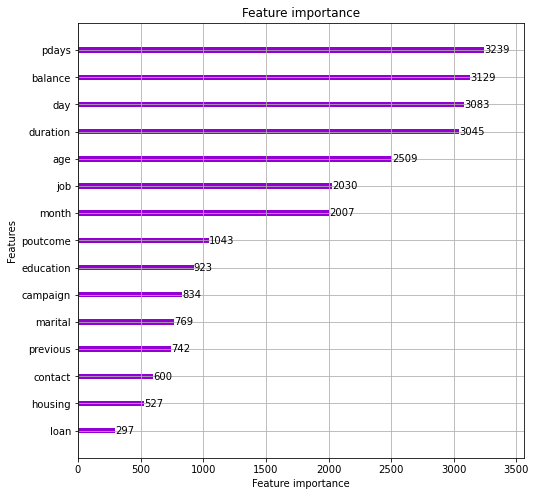

In [28]:
lgb.plot_importance(lgb_model, figsize=(8,8), color='darkviolet')

In [40]:
pred_lgb = lgb_model.predict(test_df, num_iteration=best_itr)
lgb_p = pd.DataFrame(pred_lgb)
lgb_p.head()

,0
0,0.767009
1,0.104485
2,0.039199
3,-0.003293
4,0.041867


In [41]:
now = datetime.datetime.now()

lgb_name = 'models/LGBM_op' + now.strftime('%d_%H%M') + '.pkl'
pickle.dump(best_lgb, open(lgb_name, 'wb'))

# ＜CatBoost＞

In [61]:
train_df = pd.read_csv('dataset/train_cat_16_2206.csv')
test_df = pd.read_csv('dataset/test_cat_16_2206.csv')

In [62]:
ID = test_df['id']
x = train_df.drop(columns=['y', 'id'])
y = train_df['y']
test_df = test_df.drop(columns=['y', 'id'])

In [77]:
cat_features = np.where(x.dtypes != np.float)[0]

In [64]:
x_train, x_test, y_train, y_test = train_test_split(x, y,
                                                    test_size=0.2,
                                                    stratify=y,
                                                    shuffle=True,
                                                    random_state=18)

In [72]:
def obj_cb(trial):
    
    param_cb = {
        'eval_metric': 'AUC',
        'cat_features': cat_features,
        'iterations': 10000,
        'learning_rate': trial.suggest_discrete_uniform('learning_rate', 0.01, 0.03, 0.01),
        'depth': trial.suggest_int('depth', 6, 10),
        'od_pval': trial.suggest_loguniform('od_pval', 1e-10, 1e-2),
        'od_wait': 1000,
        'l2_leaf_reg': trial.suggest_int('l2_leaf_reg', 1, 100),
        'random_strength': trial.suggest_int('random_strength', 1, 3),
        'bagging_temperature': trial.suggest_int('bagging_temperature', 1, 10),
        'random_seed': 18,
        'use_best_model': True
    }
    
    cb = CatBoostClassifier(**param_cb)
    cb.fit(x_train, y_train, eval_set=[(x_test, y_test)], early_stopping_rounds=1000, silent=True)
    predictions = cb.predict(x_test)
    auc_score = roc_auc_score(predictions, y_test)
    
    return auc_score

In [73]:
%%time

study_cb = optuna.create_study(direction='maximize')
study_cb.optimize(obj_cb, n_trials=300, n_jobs=-1)

print(study_cb.best_params)
print(study_cb.best_value)
cb_best_params = study_cb.best_params

{'learning_rate': 0.02, 'depth': 7, 'od_pval': 5.019288673918277e-06, 'l2_leaf_reg': 59, 'random_strength': 3, 'bagging_temperature': 4}
0.8607145935467757
CPU times: user 2d 3h 3min 19s, sys: 4h 22min 59s, total: 2d 7h 26min 19s
Wall time: 9h 39min 38s


In [74]:
cb_best_params

{'learning_rate': 0.02,
 'depth': 7,
 'od_pval': 5.019288673918277e-06,
 'l2_leaf_reg': 59,
 'random_strength': 3,
 'bagging_temperature': 4}

In [81]:
cb_best_params = {
        'eval_metric': 'AUC',
        'cat_features': cat_features,
        'iterations': 10000,
        'learning_rate': 0.02,
        'depth': 7,
        'od_pval': 0.000005019288673918277,
        'od_wait': 1000,
        'l2_leaf_reg': 59,
        'random_strength': 3,
        'bagging_temperature': 4,
        'random_seed': 18,
        'use_best_model': True
}



In [82]:
cb_model = CatBoostClassifier(**cb_best_params)
cb_model.fit(x_train, y_train, eval_set=[(x_test, y_test)], early_stopping_rounds=1000, silent=True)

In [84]:
cv_params = cb.get_params()
cv_params.update({
    'loss_function': 'Logloss'
})

cv_data = cv(Pool(x, y, cat_features=cat_features),
            cv_params,
            plot=True)

MetricVisualizer(layout=Layout(align_self='stretch', height='500px'))

0:	learn: 0.6711926	test: 0.6710693	best: 0.6710693 (0)	total: 123ms	remaining: 2m 2s
1:	learn: 0.6502001	test: 0.6500376	best: 0.6500376 (1)	total: 193ms	remaining: 1m 36s
2:	learn: 0.6305839	test: 0.6301000	best: 0.6301000 (2)	total: 253ms	remaining: 1m 24s
3:	learn: 0.6106543	test: 0.6100711	best: 0.6100711 (3)	total: 328ms	remaining: 1m 21s
4:	learn: 0.5931347	test: 0.5922666	best: 0.5922666 (4)	total: 371ms	remaining: 1m 13s
5:	learn: 0.5751671	test: 0.5742834	best: 0.5742834 (5)	total: 448ms	remaining: 1m 14s
6:	learn: 0.5579359	test: 0.5569355	best: 0.5569355 (6)	total: 526ms	remaining: 1m 14s
7:	learn: 0.5424831	test: 0.5414742	best: 0.5414742 (7)	total: 588ms	remaining: 1m 12s
8:	learn: 0.5279192	test: 0.5268799	best: 0.5268799 (8)	total: 661ms	remaining: 1m 12s
9:	learn: 0.5137786	test: 0.5126603	best: 0.5126603 (9)	total: 728ms	remaining: 1m 12s
10:	learn: 0.5013866	test: 0.5002795	best: 0.5002795 (10)	total: 766ms	remaining: 1m 8s
11:	learn: 0.4884579	test: 0.4871174	best: 

In [85]:
train_score_cb = cb_model.score(x_train, y_train)
test_score_cb = cb_model.score(x_test, y_test)

cb_p = cb_model.predict(x_test)

acc_cb = accuracy_score(cb_p, y_test)
auc_cb = roc_auc_score(cb_p, y_test)

print('train score:{}, test_score:{}'.format(train_score_cb, test_score_cb))
print('acc:{}, auc:{}'.format(acc_cb, auc_cb))

train score:0.9360239852398524, test_score:0.9333948339483394
acc:0.9333948339483394, auc:0.8607145935467757


Text(0.5, 0, 'Importance')

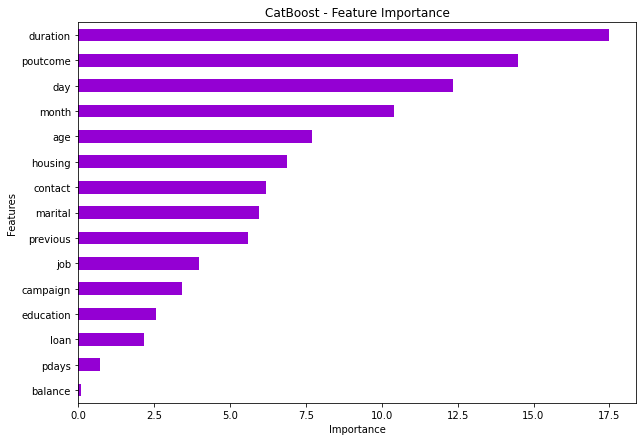

In [101]:
fea_imp = pd.DataFrame({'imp': cb_model.feature_importances_, 'col': x.columns})
fea_imp = fea_imp.sort_values(['imp', 'col'], ascending=[True, False]).iloc[-30:]
fea_imp.plot(kind='barh', x='col', y='imp', figsize=(10, 7), color='darkviolet', legend=None)
plt.title('CatBoost - Feature Importance')
plt.ylabel('Features')
plt.xlabel('Importance')

In [86]:
pred_cb = cb_model.predict_proba(test_df)
cb_p = pd.DataFrame(pred_cb)
cb_p.head()

,0,1
0,0.165193,0.834807
1,0.952910,0.047090
2,0.978363,0.021637
3,0.994338,0.005662
4,0.956605,0.043395


In [87]:
now = datetime.datetime.now()

cb_name = 'models/CatBoost_' + now.strftime('%d_%H%M') + '.pkl'
pickle.dump(cb_model, open(cb_name, 'wb'))

# ＜SUBMIT＞

In [88]:
pred = pd.DataFrame({
    'XGBoost': xgb_p[1],
    'LightGBM': lgb_p[0],
    'CatBoost': cb_p[1]
})

pred.head()

,XGBoost,LightGBM,CatBoost
0,0.850221,0.767009,0.834807
1,0.136567,0.104485,0.047090
2,0.001006,0.039199,0.021637
3,0.000054,-0.003293,0.005662
4,0.002854,0.041867,0.043395


In [90]:
print(pred.corr())

           XGBoost  LightGBM  CatBoost
XGBoost   1.000000  0.829047  0.814139
LightGBM  0.829047  1.000000  0.947095
CatBoost  0.814139  0.947095  1.000000


In [92]:
print(pred.corr())

           XGBoost  LightGBM  CatBoost
XGBoost   1.000000  0.829047  0.814139
LightGBM  0.829047  1.000000  0.947095
CatBoost  0.814139  0.947095  1.000000


In [43]:
pred['pred'] = pred.XGBoost* 0.2 + pred.LightGBM * 0.8
pred.head(10)

,XGBoost,LightGBM,pred
0,0.850221,0.767009,0.783652
1,0.136567,0.104485,0.110901
2,0.001006,0.039199,0.031560
3,0.000054,-0.003293,-0.002624
4,0.002854,0.041867,0.034064
5,0.000255,-0.002540,-0.001981
6,0.000505,0.008527,0.006923
7,0.126594,0.216017,0.198132
8,0.310138,0.041657,0.095353
9,0.004120,0.001605,0.002108


In [44]:
# ensemble

submission = pd.DataFrame({
    'ID':ID,
    'pred':pred['pred']
})

file_name = 'submit/submit_' + now.strftime('%d_%H%M') + '.csv'

submission.to_csv(file_name, header=False, index=False)

In [35]:
# XGBoost

now = datetime.datetime.now()

submission = pd.DataFrame({
    'ID':ID,
    'pred':xgb_p[1]
})

file_name = 'submit/submit_XGBoost' + now.strftime('%d_%H%M') + '.csv'

submission.to_csv(file_name, index=False, header=False)

In [34]:
# LightGBM

now = datetime.datetime.now()

submission = pd.DataFrame({
    'ID':ID,
    'pred':lgb_p[0]
})

file_name = 'submit/submit_LGBM' + now.strftime('%d_%H%M') + '.csv'

submission.to_csv(file_name, index=False, header=False)

In [93]:
# CatBoost

now = datetime.datetime.now()

submission = pd.DataFrame({
    'ID':ID,
    'pred':cb_p[1]
})

file_name = 'submit/submit_CatBoost' + now.strftime('%d_%H%M') + '.csv'

submission.to_csv(file_name, index=False, header=False)